In [55]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML, Image
import nbconvert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import sys
sys.path.insert(0, '../src/visualization')
import visualize 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

import os
plot_path = '../data/out/EDA_plots'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1 align="center">Genetic Overlap between Alzheimer's, Parkinson’s, and healthy patients</h1>
<h2 align="center">DSC180B, Section B04: Genetics</h2>
<h2 align="center">Justin Lu, Saroop Samra, Xuanyu Wu
</h2>

## Background

This study aims to find gene expression similarities and differences between patients of Alzheimer's (AD) and Parkinson's (PD). The study uses sequencing data from microRNA (abbreviated miRNA) found in two the body's biofluids, cerebrospinal fluid (CSF) and blood serum (SER). Although these disorders are experienced by many people, little is known about what specifically causes the two diseases and how to prevent or cure them. The difficulty in finding these solutions arises from the complexity of the "pathomechanisms" underlying the diseases, as well as their tendencies to have early stages that are asymptomatic, making detection very challenging until symptoms set in [<sup>1</sup>](#fn1). 

This is where our study comes into play. With our analysis, we aim to study the genetic causes underlying the two diseases by inspecting the sequencing data found in patients' bodies in the form of miRNA sequences. Uncovering the genetics behind the diseases can help researchers better their understanding of the development of AD and PD in humans and improve their chances of finding efficient preventative measures for the two disorders. Furthermore, the similarities that we may find between the disorders can aid in the research of neural disorders in general, and contribute to early diagnosis, prevention, and cures.


## Psychiatric Disorders

### Alzheimer's

Alzheimer's disease is a progressive brain disorder that heavily impacts brain function in that it slowly deteriorates memory and thinking skills, leading to symptoms like forgetting recent events or conversations, to eventually losing the ability to carry out simple tasks or even recognize friends and family members. Difficulty in reasoning and thinking is also a common symptom, especially with abstract concepts like numbers, again making everyday tasks like paying bills challenging. AD also impairs people's abilities to make decisions in everyday situations, like driving. The principal risk factor of Alzheimer's is age; people become more likely to to develop AD as they grow older. Family history can also increase a person's chances of developing the disease. A genetic link to increased chance of AD shows in the form of a variation of the gene APOE e4, something we will definitely explore further in our study. As of now, there is no known cure for AD, but medications have been known to improve or slow the effect of the disease, and programs and caregivers help to support AD patients [<sup>2</sup>](#fn2).


### Parkinson's

Parkinson's disease is a progress nervous system disorder that impacts movement. There are a myriad of symptoms that constitute PD, including a tremor (trembling) in a limb like a hand or fingers, slowed movement, rigid muscles, and impaired posture and balance. PD is also sometimes accompanies by other complications, like cognitive issues (trouble thinking, dementia), emotional changes (like depression), swallowing, chewing, and eating problems, among others. The principal risk factor of PD is age; PD usually develops in people age 60 or older. Other risk factors include family history and sex (men are more likely to develop it than women). As of now, there are no known cures or even prevention methods for Parkinson's. However, there are medications that can ease the symptoms, as well as surgeries that can regulate parts of the brain to improve symptoms [<sup>3</sup>](#fn3).



## miRNA and CSF/SER
Our sequence data comes from the encodings of microRNA strands. microRNA (miRNA) are a class of non-coding RNAs that regulate gene expression. Specifically, they bind to specific mRNA and prevent those target mRNA from translating the necessary directions to produce certain proteins. Because of the behavior of miRNA, it will be worthwhile to explore which miRNA are binding to which mRNA, and subsequently what proteins are being down-regulated (lowly expressed). These proteins could then be contributing factors to the symptoms and/or development of the two diseases [<sup>4</sup>](#fn4).

The miRNA in our study was sourced from two locations (specifically, fluids found in our body): cerebrospinal fluid (CSF) and blood serum (SER). These two fluids are part of the central nervous system, which are highly impacted by both PD and AD. CSF cushions the brain and is a "shock absorber" for the central nervous system, and also removes waste products from the brain [<sup>5</sup>](#fn5). miRNAs can be found in the CSF and have been found to be instrumental in responding to malignant tumors in the nervous system [<sup>6</sup>](#fn6). Blood serum (or serum) is the fluid that blood cells move through, but without the plasma - it is the clear liquid that remains after blood clots [<sup>7</sup>](#fn7). miRNA is found in serum as "secreted miRNAs", meaning miRNA that has been excreted from cells or tissues [<sup>8</sup>](#fn8).


## Pipeline

For this project, the basic overview of our pipeline is that we want to access our data, preform necessary quality checks (qc), then merge the inputs into a gene_matrix and feature table, normalize by outputting normalized counts, return the LRT (Likelihood Ratio Test measures how well the model fits [<sup>9</sup>](#fn9)) plots in the analysis step, and then finally visualize.

The overall pipeline is shown in Figure 1 below.

In [56]:
figNum = 1
tableNum = 1

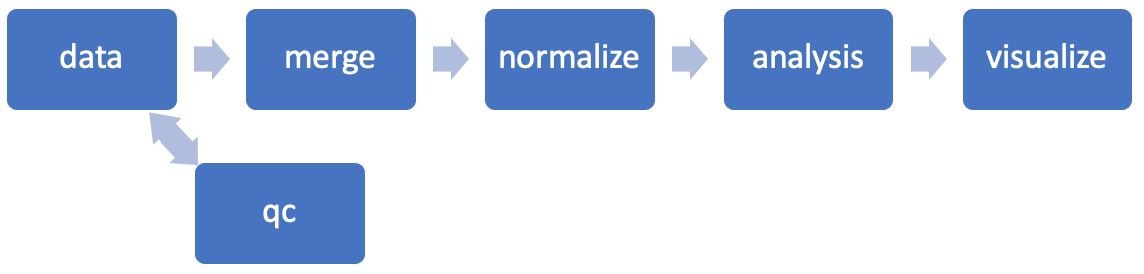

In [57]:
display(Image("pipeline/basic_pipeline.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Pipeline Overview</b>"))
figNum += 1

Given the restricted access to the raw dataset, we contacted Professor Kendall Jensen, author of the original paper, who showed us the exRNA Atlas is the data repository of the Extracellular RNA Communication Consortium (https://exrna-atlas.org/) which is a repository including small RNA sequencing and qPCR-derived exRNA profiles from human and mouse biofluids. The study processed dataset was included in this repository including the gene count matrix files for each sample.

The features table is generated from three different sources:

- <b>SRA_RunTable.csv</b>: NCBI's SRA Run table that held the age and SRA Run attributes
- <b>Table_S1.csv</b>: The attributes table from the research paper that held many other attributes such as expired age, PMI, plaque density, Braak Score.
- <b>exRNA_Atlas_CORE_Results.csv</b>: Atlas core table that held information about the codition and biofluid


These tables were all merged in the data step using Pandas merge feature, shown in Figure 2 below.

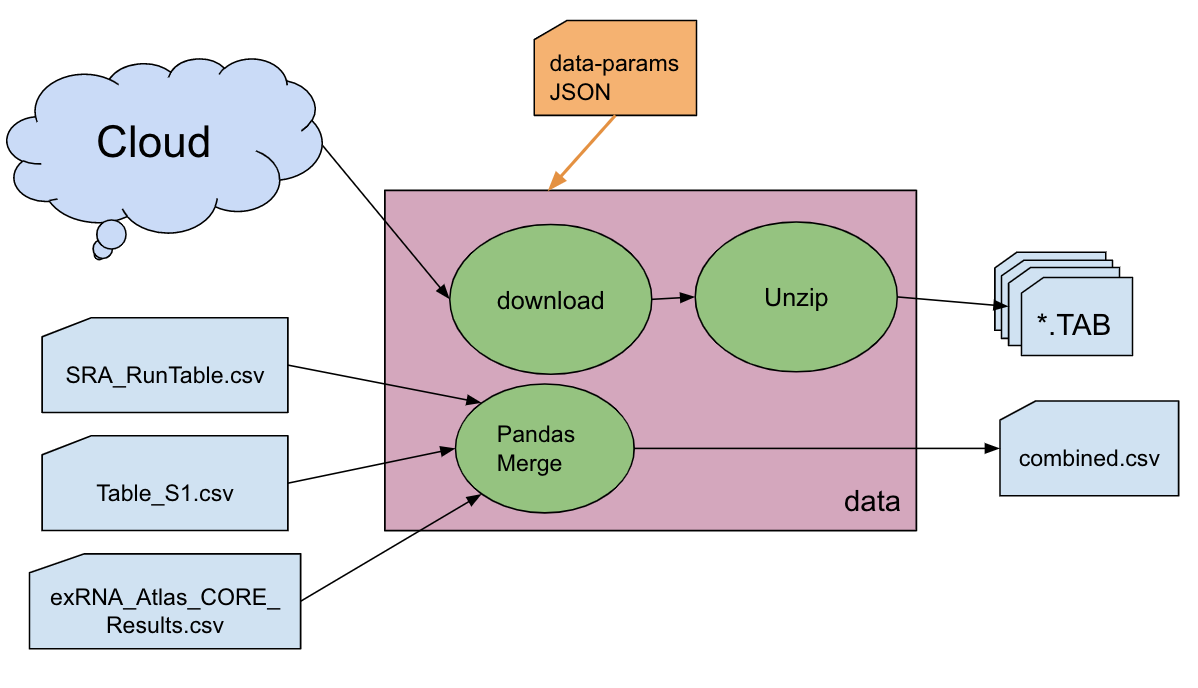

In [58]:
display(Image("pipeline/data_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Data Overview</b>"))
figNum += 1

The next step is to execute the "merge" step: which takes all the gene count SRA files and merges them in one gene matrix table using Pandas [<sup>10</sup>](#fn10). The output will also be a gene experiments table which identifies the sample labels and the patient features (age, disorder etc) shown in Figure 3 below. 

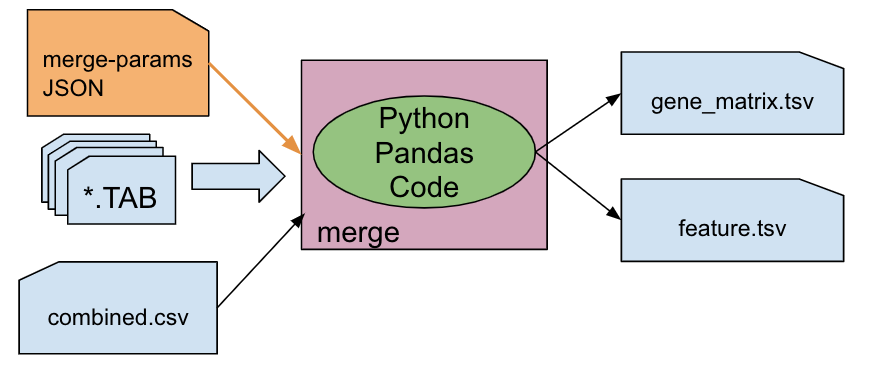

In [59]:
display(Image("pipeline/merge_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Merge Overview</b>"))
figNum += 1

After merging, we execute the "normalize" step: this imports the merged gene count matrix into a custom R script which uses the DESeq2 [<sup>11</sup>](#fn11) module to generate two normalized matrix counts: one uses standard normalization and the other Variable Stablization Transformation shown in Figure 4 below.

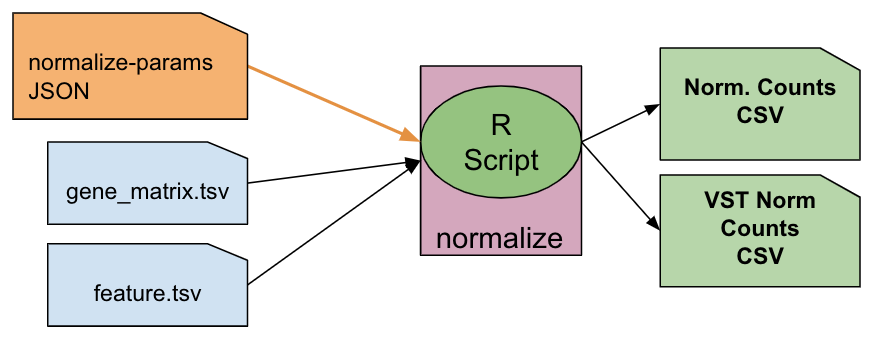

In [60]:
display(Image("pipeline/normalize_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Normalize Overview</b>"))
figNum += 1

After normalizing we execute the "analysis" step: this generates 4 Likelihood Ratio test (LRT), a hypothesis test that compares models in terms of how they fit the available data by comparing the likelihood scores of the models [<sup>9</sup>](#fn9). Each of the 4 LRT's corresponds to a one biofluid and one disorder. The LRT will be compared against that disorder versus the control group. Additionally, a MA Plot and Heatmap are generated. This is shown in Figure 5 below.

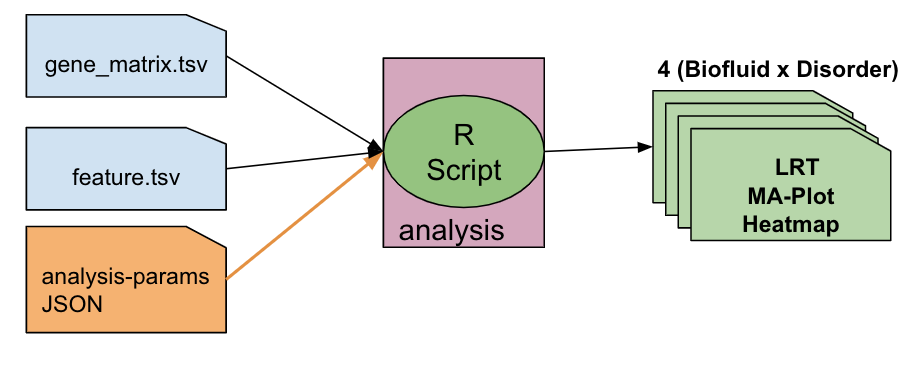

In [61]:
display(Image("pipeline/analysis_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Analysis Overview</b>"))
figNum += 1

The final step in this pipeline process is the "visualize" step. This generates the many charts and visualizations we have implemented to show the results of our findings. This step takes in the VST Norm Counts as well as the LRT MA-plot and Heatmap that are automatically generated and outputs all of our visualizations, shown in Figure 6 below. 

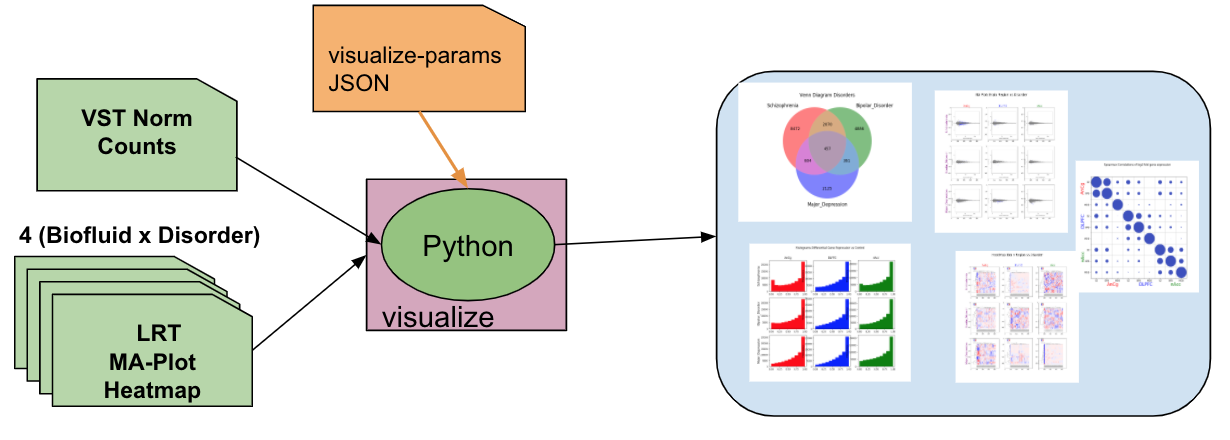

In [62]:
display(Image("pipeline/visualize_step.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Visualize Overview</b>"))
figNum += 1

Finally, Figure 7  shows the entire pipeline from start to finish. The condition column was either Parkinson's, Alzheimer's or a healthy patient. The biofluid column holds the source of where the miRNA samples was taken from, either serum or the cerebrospinal fluid.

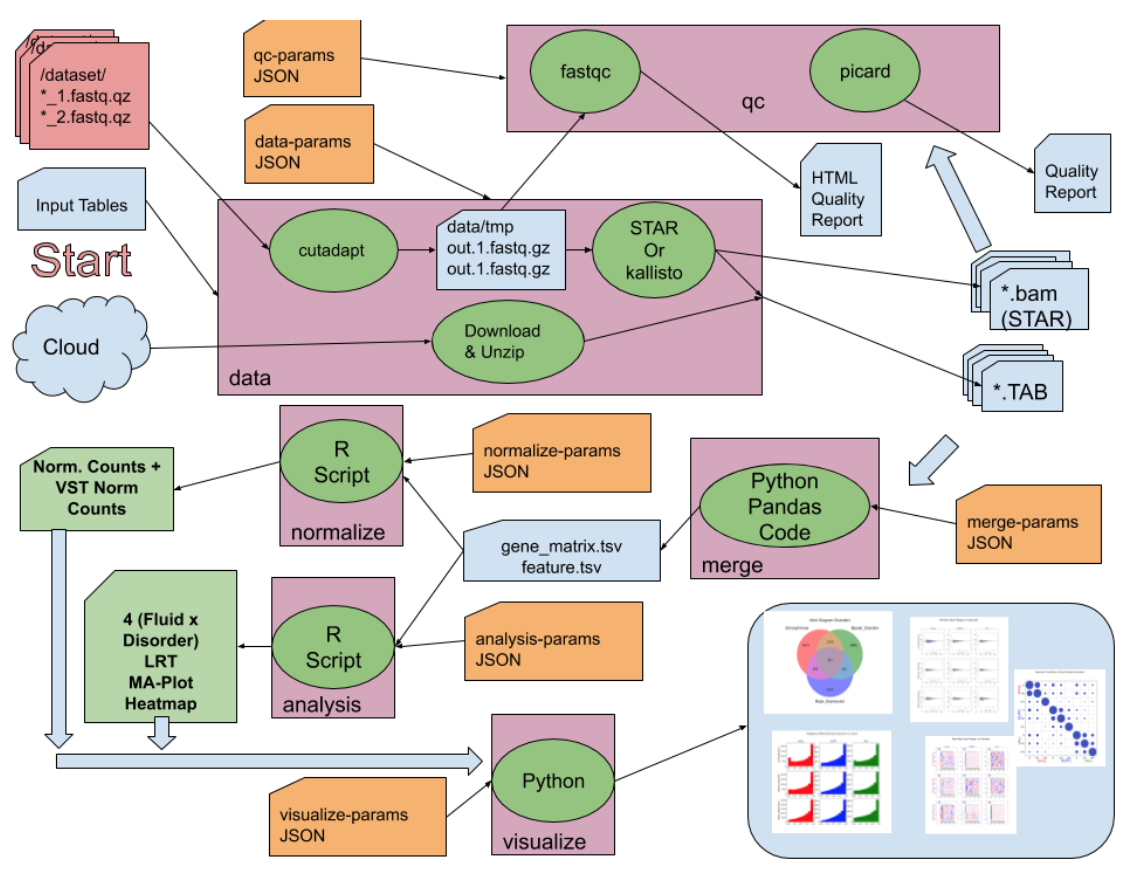

In [63]:
display(Image("pipeline/pipeline.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Pipeline Details</b>"))
figNum += 1

## Quality Checks

### Cutadapt

Cutadapt [<sup>12</sup>](#fn12) is a tool that is used by geneticists to perform data cleaning on sequence data. When sequence libraries are prepared, the process adds adapter sequences called "primers" to the actual miRNA sequences. However, those types of sequences are not relevant to our analysis, and can actually negatively affect our data quality and our subsequent results. Therefore, the cutadapt tool removes those sequences, as well as any other low-quality reads so that data is ready for analysis. However, since the data provided to us was not the "raw" data, we could not evaluate the quality of the data itself, nor could we perform any quality control like performing cutadapt. The researchers who provided the data to us most likely already performed quality checks and used a tool like cutadapt in data cleaning. 

### FastQC

FastQC [<sup>13</sup>](#fn13) is a tool that is used in checking the quality of raw sequencing data before performing large-scale analysis. The software tool calculates and outputs quality metrics of each of the sequence reads, which allows us to determine whether to keep a sequence read, to “cut away” the extraneous parts of a sequence (using cutadapt), or to leave out the read altogether. The metrics (shown as graphs and tables) include “Per sequence quality scores”, which indicates the average quality of reads over the sequences of an SRA run, “Sequence length distribution”, the distribution of sequence lengths, and an important factor, “Overrepresented sequences”, which are sequences that are not found to be in the human genome, among other measurements. Specifically for overrepresented sequences, FastQC marks these as “overrepresented” because it cannot find the source of the sequences; however, more often than not, they are adapters that have been “tacked on” during the library preparation of the sequences, and are then caught by FastQC. This is where we would use the cutadapt tool to cut out those unnecessary sections, or just completely leave the reads out of the analysis. In the end, by combining all these factors, our decision to keep or leave out sequence reads follows the ERCC (External RNA Controls Consortium) Quality Control Standards. These standards for our data (which is specifically an exRNA-seq dataset) were drawn up at a Washington, DC conference in November 2015 in order to have a universal set of quality check guidelines [<sup>14</sup>](#fn14): 
1.	An individual RNA-Seq dataset is required to have a minimum of 100,000 reads that overlap (sense or antisense) with any annotated RNA transcript in the host genome. The annotation includes all small RNAs, such as miRNAs (from miRBase), piRNAs, tRNAs, snoRNAs, and circular RNAs, as well as long transcripts from GENCODE, which includes both protein coding genes and long non-coding RNAs (lncRNAs).
2.	The fraction of reads that align to the host genome (after filtering out contaminants, adaptor dimers and ribosomal reads) that also align to any annotated RNA transcript (described in point #1) should be greater than 0.5.

Below, we compare some of the FastQC outputs for reads that were marked as "Pass" versus those marked as "Fail", shown in Figure 8.

#### SRR1568392 vs SRR1568676: failed vs passed healthy serum samples

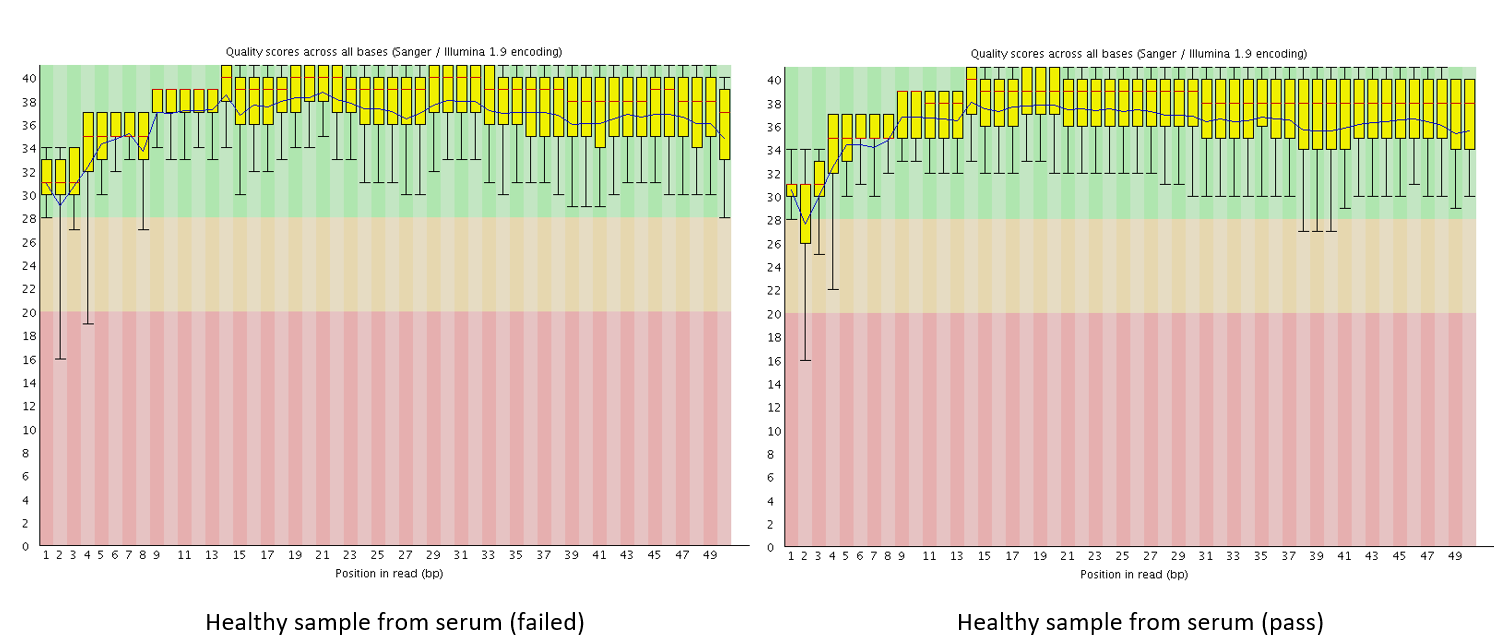

In [64]:
display(Image("SRR1568392_vs_SRR1568676/base_quality.PNG", width=800))
display(HTML("<b>Figure "+str(figNum)+": Comparison of Failed/Passed Base Quality Metrics for Healthy Serum Samples</b>"))
figNum += 1

As we can see in Figure 8, the quality of each base between the two sequence reads does not seem to be very different. It is likely that the "failed" sample on the left did not pass the ERCC quality control check for other reasons, as shown above and outlined by the ERCC. Since we do not have access to the raw sequencing data, there is no way to know for sure how they determined the ERCC pass/fail label.

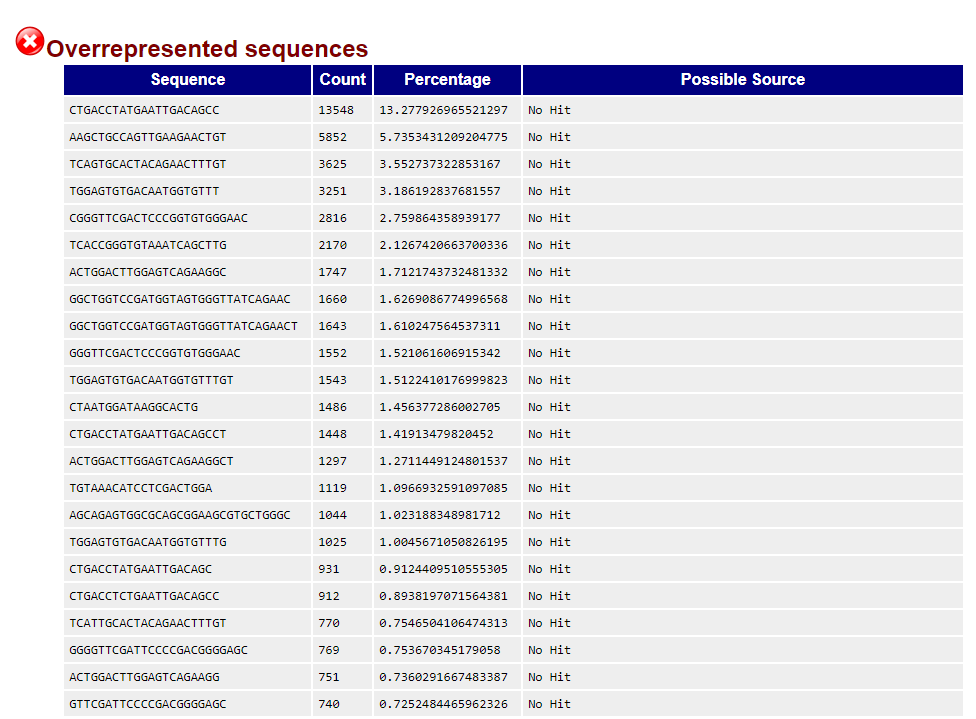

In [65]:
display(Image("SRR1568392_vs_SRR1568676/overrepresented_sequences.PNG", width=800))
display(HTML("<b>Figure "+str(figNum)+": Example of 'Overrepresented sequences' list</b>"))
figNum += 1

Shown in Figure 9 is an example of a table/list of overrepresented sequences that FastQC detects in a sequence read. FastQC labels these as either possible primer sequences (by matching with primers that certain tools, like Illumina, use), or just "No Hit", meaning an unknown source. Either way, it is a starting point for cleaning any sequences that failed the FastQC check, by removing these sequences with tools like cutadapt. Otherwise, we could just leave that sequence read out of our analysis.


#### SRR1568365 vs SRR1568510: failed vs passed Parkinson's serum samples

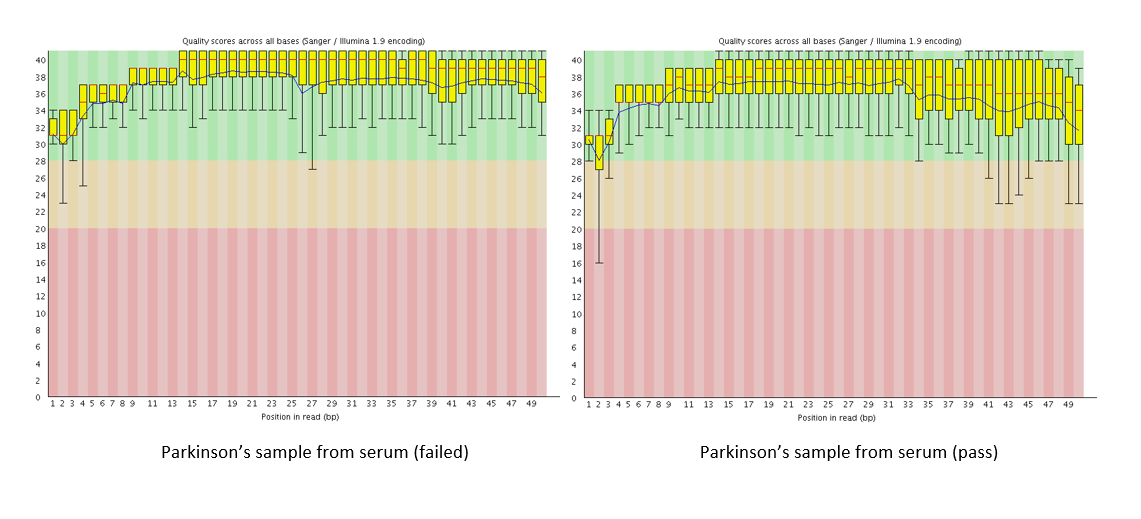

In [66]:
display(Image("SRR1568365_vs_SRR1568510/base_quality.PNG", width=800))
display(HTML("<b>Figure "+str(figNum)+": Comparison of Failed/Passed Base Quality Metrics for Parkinson's Serum Samples</b>"))
figNum += 1

Figure 10 shows the base quality over the sequences of the two samples does is not vastly different. Yet, the sample on the left did not pass the ERCC quality check. So, looking further into the report, we note below that the sample on the left did have an abnormal amount of N bases, which, in DNA sequencing terms, usually means "unspecified", or a base that could be attributed to any of the 4 (A, T, G, C) main bases [<sup>15</sup>](#fn15). This uncertainty is not meaningful and does not bode well for analysis, so the sequence itself was removed. There could also have been other factors to this removal, particularly in regard to the ERCC standards.

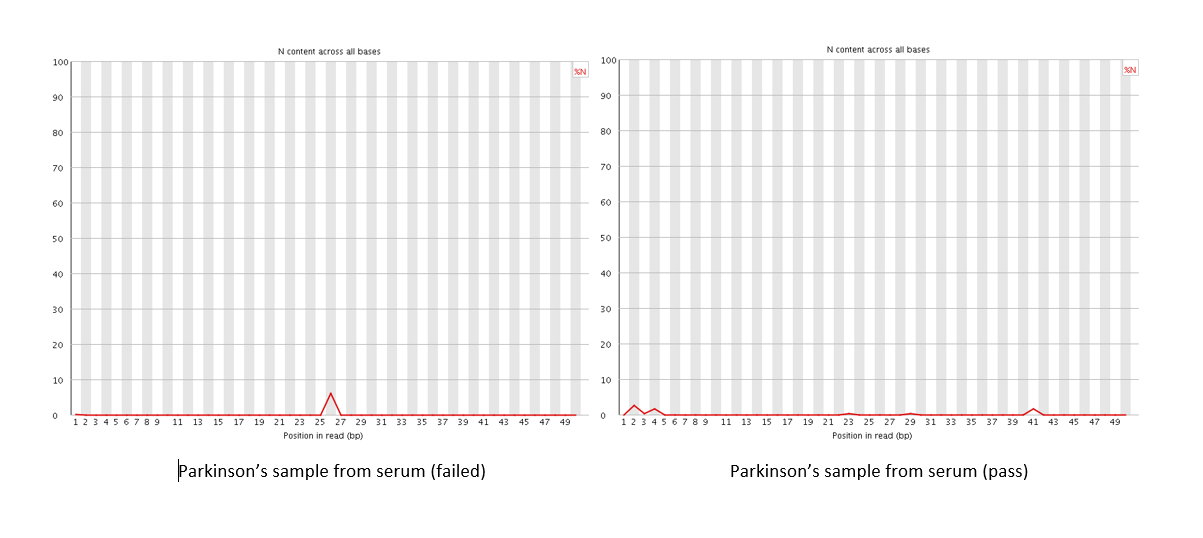

In [67]:
display(Image("SRR1568365_vs_SRR1568510/n_content.PNG", width=800))
display(HTML("<b>Figure "+str(figNum)+": Comparison of Failed/Passed N Content</b>"))
figNum += 1

## EDA

### Experiments Features Table

The `Run` column in the features table represents a unique "ID" of the sample collection for a patient in our study. Each patient (healthy, Parkinson's, or Alzheimer's) has a sequencing sample run associated with it, and serves to uniquely identify the sample in our study. The `CONDITION` column corresponds to the disease that each patient was afflicted by (Alzheimer's or Parkinson's), or if the patient was part of the control group (healthy). The `BIOFLUID` column designates the source of the sample from the patient's body (CSF or serum). `sex` and `expired_age` are the gender of the subject, and the age of the subject at death, respectively. The `PMI` column stands for "post-mortem interval", which means the amount of time between the subject's death and when the sample was collected from the body of the subject. `PlaqueTotal`, `Plaque density`, and `TangleTotal` all correspond to the amounts of structures called plaques and tangles in the brain. Plaques are dense clumps in the space between nerve cells in the brain, and are known to negatively impact the brain cells around it. When they develop around brain areas like the hippocampus (which a part of the brain that is fundamental in the process of making memories), it leads to the dementia symptoms of Alzheimer's. Tangles are also structures that develop in the brain that negatively affect the transportation of neurons to and from certain areas, altogether inhibiting brain function. `Braak score`, also referred to as "braak stage" is a score that is used to measure the degree of brain disfunction for both Alzheimer's and Parkinson's patients. `LB Stage` corresponds to the stage of lewy body dementia, which is often related to Parkinson's disease. Lewy bodies are clumps of proteins that develop in areas of the brain responsible for memory and movement - both are impacted by Parkinson's. `NIA-R` is the modified NIA-Reagan diagnosis of Alzheimer's disease is based on consensus recommendations for postmortem diagnosis of Alzheimer's disease. The criteria rely on both neurofibrillary tangles (Braak) and neuritic plaques (CERAD).
Finally, `sn_depigmentation` is short for substantia nigra depigmentation. The substantia nigra is a part of the midbrain; this brain region is usually found to be depigmented in Parkinson's disease patients. 

By inspecting these features, specifically performing EDA and doing research on what each of the values mean, we can delve further into the analysis by determining what features will be important in the differential gene analysis model in DESeq2, and which of them will significantly differentiate between Alzheimer's, Parkinson's and healthy patients in terms of their genetics. 

In [68]:
sra = pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv", index_col=0)

display(sra[["Run", "CONDITION", "BIOFLUID", "sex", 'expired_age', 'PMI', 'PlaqueTotal', 'Plaque density', 'TangleTotal', 'Braak score', 'LB Stage', 'sn_depigmentation']])
display(HTML("<b>Table "+str(tableNum)+": Feature attributes</b>"))
tableNum += 1

,Run,CONDITION,BIOFLUID,sex,expired_age,PMI,PlaqueTotal,Plaque density,TangleTotal,Braak score,LB Stage,sn_depigmentation
0,SRR1568567,Healthy Control,Cerebrospinal fluid,male,94,2.50,15.00,frequent,12.00,IV,No Lewy bodies,none
1,SRR1568730,Parkinson's Disease,Serum,female,79,6.00,2.75,sparse,3.25,II,Limbic type,severe
2,SRR1568666,Alzheimer's Disease,Serum,female,81,2.50,11.50,frequent,11.10,V,No Lewy bodies,mild
3,SRR1568510,Parkinson's Disease,Cerebrospinal fluid,male,79,2.50,7.50,moderate,3.00,II,Neocortical type,severe
4,SRR1568518,Parkinson's Disease,Cerebrospinal fluid,female,82,4.16,0.00,zero,6.50,III,Limbic type,severe
...,...,...,...,...,...,...,...,...,...,...,...,...
338,SRR1568457,Parkinson's Disease,Cerebrospinal fluid,female,79,3.50,13.25,moderate,6.50,IV,Neocortical type,severe
339,SRR1568654,Healthy Control,Serum,male,84,2.66,7.00,sparse,4.00,III,No Lewy bodies,none
340,SRR1568729,Parkinson's Disease,Cerebrospinal fluid,female,79,6.00,2.75,sparse,3.25,II,Limbic type,severe
341,SRR1568430,Parkinson's Disease,Cerebrospinal fluid,male,79,4.50,0.25,zero,1.75,II,Limbic type,severe


## General Patient Population


### Uniqueness of the Data

After checking the uniqueness of the data there is only one sample from a single area of interest for one subject. So we need to keep in mind that there may exist cross-subject differences for samples of different biofluids

### Gender & Condition Breakdown of Each Biofluid

We broke down the samples into two groups based on biofluid, and then looked at the distribution of other variables, namely gender, expired age, disease duration, PMI, total number of plaques, and total number of tangles.

This dataset is conprised of 126 healthy control subjects, 110 subjects of Alzheimer's Diseases , and 107 Parkinson's Diseases patients.

Then, we broke the population by gender and biofluids. Although the gender distribution is mostly balanced, the dataset contains significantly more female samples in the Parkinson's disease group. Therefore, gender bias could potentially affect the result of our analysis.

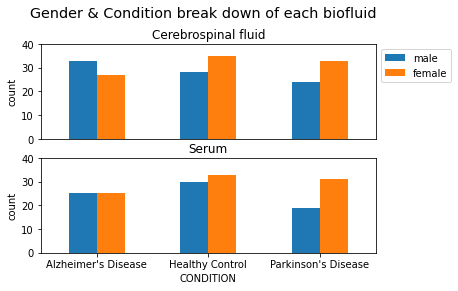

In [69]:
#sample furthur break-down by gender
cnt_summary_CSF = sra[sra['BIOFLUID']=='Cerebrospinal fluid'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
cnt_summary_serum = sra[sra['BIOFLUID']=='Serum'][['CONDITION', 'BIOFLUID', 'sex']].groupby(['CONDITION', 'sex']).count().unstack()
fig, (ax1, ax2) = plt.subplots(2, 1)
cnt_summary_CSF.plot.bar(ax = ax1)
ax1.legend(['male', 'female'], bbox_to_anchor=(1, 1))
ax1.set_title('Cerebrospinal fluid')
ax1.set_ylim(0,40)
ax1.set_ylabel('count')
ax1.xaxis.set_visible(False)

cnt_summary_serum.plot.bar(ax = ax2)
ax2.set_title('Serum')
ax2.legend().remove()
ax2.set_ylim(0,40)
ax2.set_ylabel('count')
plt.xticks(rotation = 0)
fig.suptitle('Gender & Condition break down of each biofluid', fontsize='x-large')
fig.subplots_adjust(top=0.85)

fig.savefig(os.path.join(plot_path, 'gender_cond_biofluid.png'))

plt.show()
display(HTML("<b>Figure "+str(figNum)+": Samples break down by gender and biofluid.</b>"))
figNum += 1



### Variable distributions Brocken Down by Group in CSF and Serum

As shown below, when comparing across conditions, more samples in the healthy control group has larger expired age in both CSF and Serum sample populations. The Alzheimer's group has shorter PMI but higher total numbers of plaque and tangle in both CSF and Serum samples. When comparing across biofluids sample populations, the Alzheimer's group has higher expired age in CSF population than in Serum population. The Parkinson's group in the CSF population has slightly larger disease durations.

Although the distributions have slight differences, the distinction between the distribution of the samples of cerebrospinal fluid and that of serum is not too drastic to a degree where we need to handle anything specially in our downstream analysis. 

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


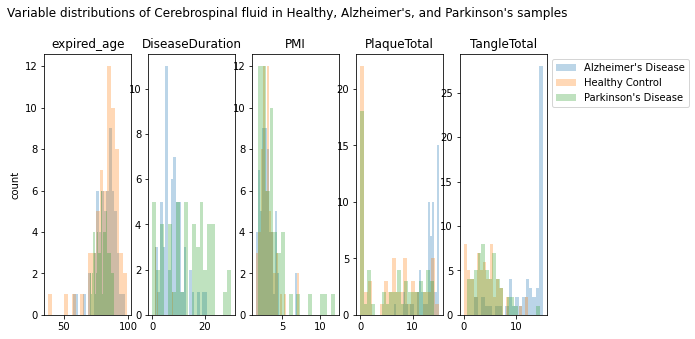

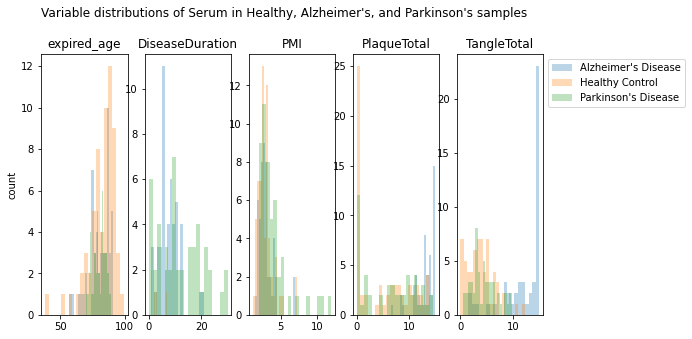

In [70]:
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
biofluids = sra.BIOFLUID.unique()
num_bins = 20
variables = ['expired_age', 'DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']
for i in biofluids:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    fig.set_figheight(5)
    fig.set_figwidth(9)
    ax_arr = [ax1, ax2, ax3, ax4, ax5]
    fig.suptitle('Variable distributions of %s in Healthy, Alzheimer\'s, and Parkinson\'s samples' % i)
    fig.subplots_adjust(top=0.85)
    for j in conditions:
        for k in range(len(variables)):
            data = sra.loc[(sra['CONDITION']==j) & (sra['BIOFLUID']==i)][variables[k]]
            ax = ax_arr[k]
            ax.hist(data, bins=num_bins,label=j, alpha = 0.3)
            ax.set_title(variables[k])
            if k==0:
                ax.set_ylabel('count')
        ax.legend(bbox_to_anchor=(1, 1))
            
    fig.savefig(os.path.join(plot_path, 'num_variable_distr_%s.png'%i))  

plt.show()
display(HTML("<b>Figure "+str(figNum)+": Distributions of the above variables.</b>"))
figNum += 1

### "Disorder Markers" 


As mentioned previously, NIA-R is a measurement for diagnosing Alzheimer's disease. We wanted to validate if the values of the samples in our dataset reflect this claim.

In the panel A, we saw that all the healthy control samples are either under the category "criteria not met" or "no AD". Surprisingly, although it is expected that most of the AD samples are under the category "high" there are some of the PD samples under "intermediate" and "low" categories. It might suggest that there exist some commonalities between AD and PD.

Since lewy bodies are closely associated with Parkinson's disease, it is reasonable to see there are only Parkinson's samples in the LB stage categories in panel B below. Among those samples, most of them are under limbic type and neocortical type. Under "No lewy bodies" category, there are no Parkinson's patients, which further proved that lewy bodies is specific to Parkinson's disease in our dataset.

According to [Peowe et al.](https://www.nature.com/articles/nrdp201713#Sec3), compared to control, parkinson's disease is defined by sn depigmentation. So it is intuitive to see, in panel C, the parkinson's group has the most severe cases. However, same as what happened in NIA-R distribution, there is not a clear separation between AD and PD, namely, there are still some AD patients in the "mild", "moderate", or even "severe" categories.


Braak score is used to classify the degree of pathology in both PD and AD. However, in our dataset, although we can see a clearly different distribution for AD patients (the count increases as the stages go higher), there is no clear separation between the PD patients and the healthy control (panel D). It could be the case that this is what the data should look like, but we cannot exclude the possibility that there is something wrong with this feature, like wrong data entry, unspecified standard changes, etc..)

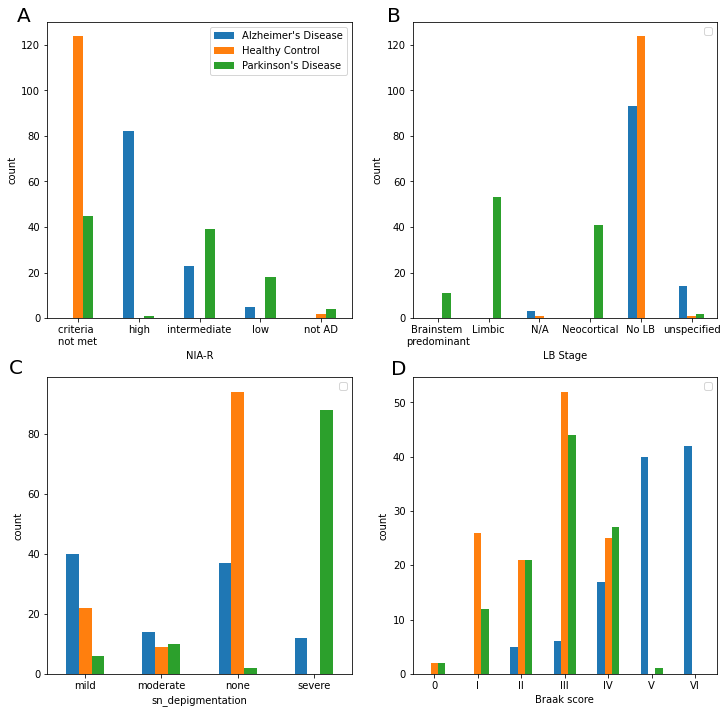

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
# distribution of NIA-R droken down by conditions
conditions = ['Alzheimer\'s Disease', 'Healthy Control', 'Parkinson\'s Disease']
nia_mapper = {'criteria not met': 'criteria \nnot met'}
sra['NIA-R'] = sra['NIA-R'].replace(nia_mapper)
nia_r = sra.groupby(['NIA-R','CONDITION']).size().to_frame()
nia_r.unstack().plot(kind='bar', ax = ax[0, 0])

ax[0, 0].legend(conditions, loc = 'best')
ax[0, 0].set_ylabel('count')
ax[0, 0].set_xticklabels([x for x in nia_r.unstack().index], rotation=0)
plt.savefig(os.path.join(plot_path, 'NIA-R.png'))
ax[0, 0].text(-1, 130,'A', size=20)
# lb stage
lb_mapper = {'LB pathology unspecified or not further assessed': 'unspecified', np.nan: 'N/A', 
             'Brainstem predominant type': 'Brainstem \npredominant', 
             'Limbic type': 'Limbic',
             'Neocortical type': 'Neocortical',
             'No Lewy bodies': 'No LB'
            }
sra['LB Stage'] = sra['LB Stage'].replace(lb_mapper)
lb_stage = sra.groupby(['LB Stage', 'CONDITION']).size().to_frame()
lb_stage.unstack().plot(kind='bar', ax = ax[0, 1])
ax[0, 1].legend([])
ax[0, 1].set_ylabel('count')
ax[0, 1].set_xticklabels([x for x in lb_stage.unstack().index], rotation=0)
plt.savefig(os.path.join(plot_path, 'LB_stage.png'))
ax[0, 1].text(-1, 130,'B', size=20)
#sn_depigmentation
sn_dp = sra.groupby(['sn_depigmentation', 'CONDITION']).size().to_frame()
sn_dp.unstack().plot(kind='bar', ax = ax[1, 0])
ax[1, 0].set_xticklabels([x for x in sn_dp.unstack().index], rotation = 0)
ax[1, 0].set_ylabel('count')
ax[1, 0].legend([])
plt.savefig(os.path.join(plot_path, 'sn_depigmentation.png'))
ax[1, 0].text(-1, 100,'C', size=20)
#braak score
bs_cnts = sra.groupby(['Braak score','CONDITION']).size().to_frame()
bs_cnts.unstack().plot(kind='bar', ax = ax[1, 1])
ax[1, 1].set_xticklabels([x for x in bs_cnts.unstack().index], rotation = 0)
ax[1, 1].set_ylabel('count')
ax[1, 1].legend([])
plt.savefig(os.path.join(plot_path, 'Braak_score.png'))
ax[1, 1].text(-1, 55, 'D', size=20)

plt.show()
display(HTML("<b>Figure "+str(figNum)+": \"Disorder Markers\" Distribution of Healthy, Alzheimer\'s, and Parkinson\'s samples.</b>"))
figNum += 1

## Biofluid Region

During our EDA of the three biofluid regions specified in the replication project, we narrowed our focus on seeing how correlated the two biofluid regions of the study were when it came to the variables.

#### Mean Break Down of Disorders at Each Biofluid

In the table below, we can see determine some important information about patients that suffer from the diseases versus healthy patient samples. Clearly, the plaque and tangle counts are much higher in Alzheimer's patients, which is expected because these structures are found primarily in the brains of people with Alzheimer's. Another important point to note is that the disease duration of Parkinson's patients is significantly higher than the other people, due to the fact that Parkinson's is a slowly progressive disorder and develops gradually (more gradually than Alzheimer's). Therefore, the average disease duration of Parkinson's is much higher than the other patients. 

Source: https://www.parkinsonsvic.org.au/parkinsons-and-you/how-does-parkinsons-progress/

In [72]:
# Averages broken down by source_name
region_info = sra.groupby(['CONDITION', 'BIOFLUID'])['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal'].mean()
display(region_info.round(3))
display(HTML("<b>Table "+str(tableNum)+": Numeric feature attributes Grouped By Condition and Biofluid</b>"))
tableNum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


expired_age  DiseaseDuration    PMI  \
CONDITION           BIOFLUID                                                   
Alzheimer's Disease Cerebrospinal fluid       81.633            7.569  2.942   
                    Serum                     80.260            7.146  2.999   
Healthy Control     Cerebrospinal fluid       81.984            3.286  3.019   
                    Serum                     81.714            3.167  2.878   
Parkinson's Disease Cerebrospinal fluid       79.895           13.173  3.731   
                    Serum                     80.140           11.851  3.876   

                                         PlaqueTotal  TangleTotal  
CONDITION           BIOFLUID                                       
Alzheimer's Disease Cerebrospinal fluid       13.104       12.078  
                    Serum                     13.102       12.034  
Healthy Control     Cerebrospinal fluid        5.321        3.910  
                    Serum                      4.943        3.720  
Parkinson's Disease Cerebrospinal fluid        5.768        4.535  
                    Serum                      6.185        4.375

### Correlation Observation of the Serum Biofluid

Here, we inspect the correlation between features in our feature table, specifically the samples collected from serum. The most positively correlated variables seem to be `PlaqueTotal` and `TangleTotal` with a high correlation of 0.71; this follows because the presence (or absence) of both the plaque and tangle structures in the brain is related to whether or not someone has Alzheimer's disease, as these structures affect the brain in ways that cause the symptoms of AD. Another set of variables that seem to be positively correlated is `PMI` and `DiseaseDuration`, with a correlation of 0.26. This correlation could be a result of the researchers' process for sample collection, since post-mortem interval and disease duration do not seem to have a genetic or biological relationship. `DiseaseDuration` has a negative correlation with both `PlaqueTotal` and `TangleTotal`, meaning they have "opposite" trends. When the duration of the disease is long, then both plaque and tangle amounts are small, and vice versa.

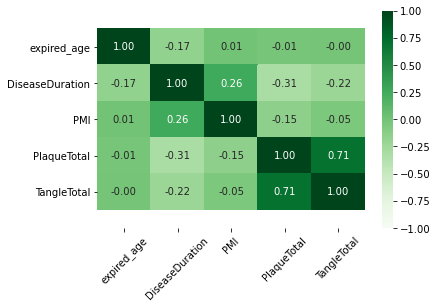

<Figure size 432x288 with 0 Axes>

In [73]:
# Serum Correlation Observation
Serum_region = sra[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']][sra['BIOFLUID'].str.contains("Serum")]
Serum_corr_data = Serum_region.corr()
sns.heatmap(Serum_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Serum Biofluid Heatmap Correlations.</b>"))
figNum += 1
plt.savefig(os.path.join(plot_path, 'corr_serum.png'))

### Correlation Observation of the Cerebrospinal Biofluid

Here, we are exploring the correlation between features in our feature table, specifically the samples collected from cerebrospinal fluid. Again, the most positively correlated variables are `PlaqueTotal` and `TangleTotal`, both of which are found in similar amounts in Alzheimer's patients. `DiseaseDuration` and `expired_age` were found to be negatively correlated, which follows because if the disease lasts a prolonged period of time, the patient is more likely to die sooner rather than later.

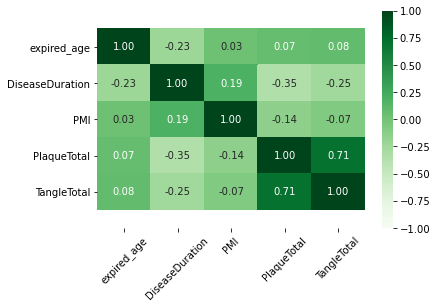

<Figure size 432x288 with 0 Axes>

In [74]:
# Cerebrospinal fluid Correlation Observation
Cerebrospinal_region = sra[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']][sra['BIOFLUID'].str.contains("Cerebrospinal fluid")]
Cerebrospinal_corr_data = Cerebrospinal_region.corr()
sns.heatmap(Cerebrospinal_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Cerebrospinal Biofluid Heatmap Correlations.</b>"))
figNum += 1
plt.savefig(os.path.join(plot_path, 'corr_csf.png'))

We have seen that the overall correlation between Plaque total and plaque total in both biofluid samples are high, but after previous investigation, we know that the distribution of those two measurements are different for AD group. Therefore, it is reasonable to furthur investigate those two correlations by breaking them down by conditions.

In [75]:
display(sra[sra.BIOFLUID=='Serum'].groupby('CONDITION')[['PlaqueTotal', 'TangleTotal']].corr())
display(HTML("<b>Table "+str(tableNum)+": Serum Biofluid PlaqueTotal and TangleTotal Correlation broken down by conditions </b>"))
tableNum += 1

PlaqueTotal  TangleTotal
CONDITION                                                
Alzheimer's Disease PlaqueTotal     1.000000     0.681418
                    TangleTotal     0.681418     1.000000
Healthy Control     PlaqueTotal     1.000000     0.424554
                    TangleTotal     0.424554     1.000000
Parkinson's Disease PlaqueTotal     1.000000     0.505350
                    TangleTotal     0.505350     1.000000

In [76]:
display(sra[sra.BIOFLUID=='Cerebrospinal fluid'].groupby('CONDITION')[['PlaqueTotal', 'TangleTotal']].corr())
display(HTML("<b>Table "+str(tableNum)+": Cerebrospinal Biofluid PlaqueTotal and TangleTotal Correlation broken down by conditions </b>"))
tableNum += 1

PlaqueTotal  TangleTotal
CONDITION                                                
Alzheimer's Disease PlaqueTotal     1.000000     0.676371
                    TangleTotal     0.676371     1.000000
Healthy Control     PlaqueTotal     1.000000     0.424364
                    TangleTotal     0.424364     1.000000
Parkinson's Disease PlaqueTotal     1.000000     0.484219
                    TangleTotal     0.484219     1.000000

The above matrix showed that althought the plaque total and tangle total in all three groups have fairly high correlation, AD group contributed the most to the high correlation between the two variables.

## Gene Matrix

Another important step before we step into the formal analysis is to get famillar with our gene matrix. Here, we explored some basic properties including counts, missingness, basic distributions and basic correlations.


In the full gene matrix that includes all the sequences, we have a lot of NaN values because not every sequence is detected in our sample.

We started by looking at how many sequences are missing for one sample and how many samples do not have a certain sequence, that is, the number of missing value of the columns and rows of the matrix.

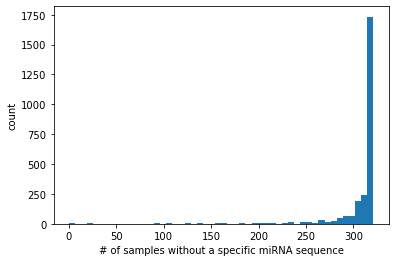

In [77]:
gm_full = pd.read_csv('../data/out/gene_matrix_full.tsv', sep='\t', index_col=0)
# miRNA count missingness
num_missing_seq = gm_full.isna().sum(axis = 1)
plt.hist(num_missing_seq,bins=50)
plt.ylabel('count')
plt.xlabel('# of samples without a specific miRNA sequence')
plt.savefig(os.path.join(plot_path, 'miRNA_missingness.png'))

plt.show()
display(HTML("<b>Figure "+str(figNum)+": Distribution of miRNA count missingness.</b>"))
figNum += 1

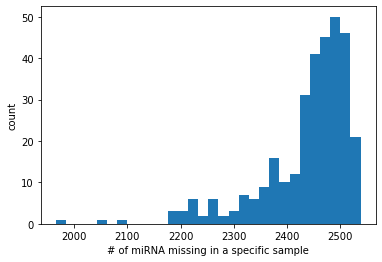

In [78]:
# missingness of the samples
num_missing_samp = gm_full.isna().sum(axis = 0)
plt.hist(num_missing_samp, bins=30)
plt.ylabel('count')
plt.xlabel('# of miRNA missing in a specific sample')
plt.savefig(os.path.join(plot_path, 'sample_missingness.png'))

plt.show()
display(HTML("<b>Figure "+str(figNum)+": Distribution of missingness of samples.</b>"))
figNum += 1

## QC Standards

<font color="red">TODO.</font>

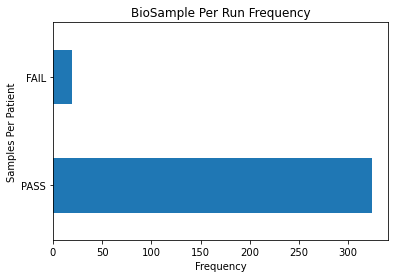

,MEETS ERCC QC STANDARDS?
PASS,324
FAIL,19


In [79]:
ax = sra["MEETS ERCC QC STANDARDS?"].value_counts().plot(kind='barh')
ax.set_xlabel("Frequency")
ax = ax.set_ylabel("Samples Per Patient")
plt.title("BioSample Per Run Frequency")
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Pass and Fail SRA Samples.</b>"))
figNum += 1


display(sra["MEETS ERCC QC STANDARDS?"].value_counts().to_frame())
display(HTML("<b>Table "+str(tableNum)+": Pass and Fail SRA Samples</b>"))
tableNum += 1

## Processing of Data

### Merging counts

The downloaded file package per sample contained a TSV gene count file. The table has a column that indicates the abundance count. The 322 abundance files were merged into one gene count file. Special care was needed to ensure that the columns and rows matches up - the columns were the SRA runs, and the rows were the gene counts. The output was a table with over 180K genes, however most of the genes had no overlap amonst the SRA samples. After removing null rows, the final gene matrix table had 400+ miRNA.  A portion of the final gene matrix table is shown in Table 8 below. 

In [80]:
df1 = pd.read_csv("../data/out/gene_matrix.tsv", sep='\t', index_col=0)
df1["sum"] = df1.sum(axis=1).sort_values(ascending=False)
display(df1.sort_values("sum", ascending=False).iloc[0:4,0:4].astype(int))
display(HTML("<b>Table "+str(tableNum)+": Subset of the gene matrix of top 4 miRNA's based on count versus first 4 SRA Run's.</b>"))
tableNum += 1

,SRR1568661,SRR1568516,SRR1568489,SRR1568596
miRNAs,,,,
mir-39-3p,8,114,19,47
mir-54,1,137,18,29
mir-238,1,133,9,36
mir-22-3p,3,42,1,6


Another output of the merge step was to generate the feature experiment table which has the features of interest for all the SRA Run's.

In [81]:
df2 = pd.read_csv("../data/out/features.tsv", sep='\t', index_col=0)
display(df2)
display(HTML("<b>Table "+str(tableNum)+": Feature table.</b>"))
tableNum += 1

,Disorder,expired_age,Biofluid,sex,PMI,sn_depigmentation,Braak_Score,TangleTotal,Plaque_density,PlaqueTotal
Run,,,,,,,,,,
SRR1568567,Control,94,Cerebrospinal,male,2.50,none,IV,12.00,frequent,15.00
SRR1568730,Parkinson,79,Serum,female,6.00,severe,II,3.25,sparse,2.75
SRR1568666,Alzheimer,81,Serum,female,2.50,mild,V,11.10,frequent,11.50
SRR1568510,Parkinson,79,Cerebrospinal,male,2.50,severe,II,3.00,moderate,7.50
SRR1568518,Parkinson,82,Cerebrospinal,female,4.16,severe,III,6.50,zero,0.00
...,...,...,...,...,...,...,...,...,...,...
SRR1568457,Parkinson,79,Cerebrospinal,female,3.50,severe,IV,6.50,moderate,13.25
SRR1568654,Control,84,Serum,male,2.66,none,III,4.00,sparse,7.00
SRR1568729,Parkinson,79,Cerebrospinal,female,6.00,severe,II,3.25,sparse,2.75


Furthermore, the following cleanup was done in the merge step:

- The sample SRR1568391 was removed due to SRA Run table having two rows which had both the same SRA number but with different values. 

- The imputation with TangleTotal attribute as it had missing data which was replaced with the mean.

### Normalized Gene Count 

The process of normalization used the merged gene matrix and feature experiment table generated from the merge step, and then used DESeq2's transform to generate a normalized count matrix file. As well as outputing the standard normalized count matrix we also performed Variance Stabilization Transformation (VST) to generate an additional normalized matrix which used the parametric fitting type. VST transforms data is by creating new values in terms of y where the variability of the new y-values is unrelated to the x-values[<sup>11</sup>](#fn11). VST finds a function that can be applied to the original x values to generate the new y-values. Methods like VST and normalization allow us to primarily scale our data so that its in a format that allows us to perform further analysis. The values in our data become more manageable all while still maintaing their original statistical importance and meaning, especially if our variables in our pre-normalized data have different scales[<sup>12</sup>](#fn12).

The descriptive statistics for both the normalized and the VST normalized gene matrix is shown in Table 10 and 11 below. 

In [82]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/normalized_counts.tsv", sep='\t', index_col=0)

display(df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3))

display(HTML("<b>Table "+str(tableNum)+": Normalized gene matrix descriptive statistics summarized for all samples.</b>"))
tableNum += 1

,Average Sample
count,400.000
mean,1.742
std,5.366
min,1.018
25%,1.018
50%,1.018
75%,1.034
max,70.782


In [83]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/vst_transformed_counts.tsv", sep='\t', index_col=0)
display(df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3))
display(HTML("<b>Table "+str(tableNum)+": VST gene matrix descriptive statistics summarized for all samples.</b>"))
tableNum += 1

,Average Sample
count,400.000
mean,0.263
std,0.679
min,0.087
25%,0.087
50%,0.087
75%,0.101
max,6.045


The descriptive statistics showed as expected the VST had a smaller range of values. However, we wanted to verify that the two sets of normalized gene count matrices where correlated. For this we took a number of SRA samples from each matrix and compared them against each other. Figure 13 below shows the correlation for SRR1568567 as well as SRR1568584. The result of the R2 Pearson correlation of 0.97 shows a strong indication that the data from both matrices is consistent. For further downstream processing, we used the VST gene matrix.

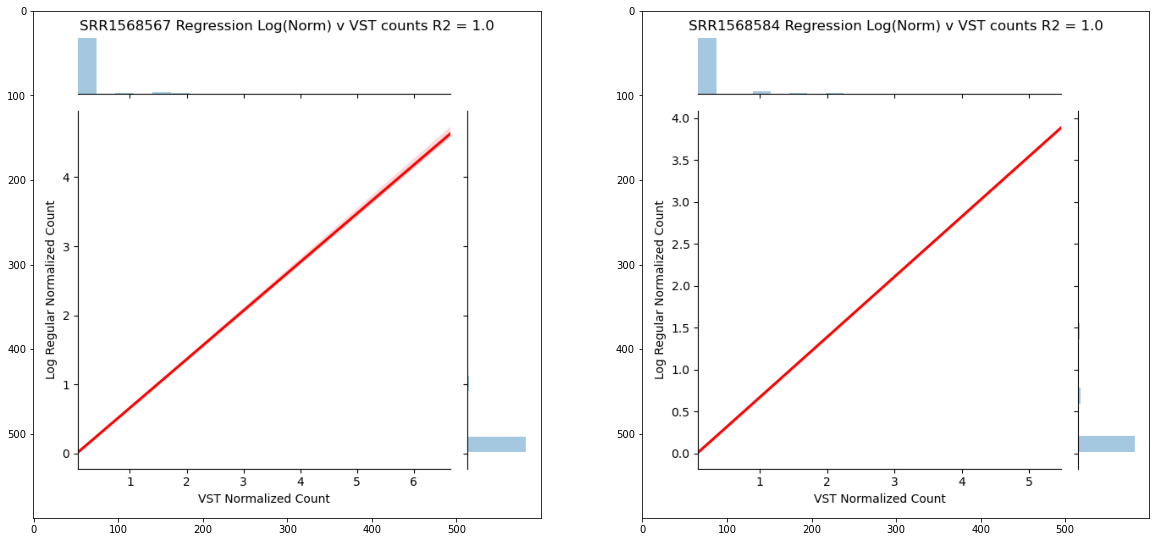

In [84]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/sra_1.png')
img_B = mpimg.imread('../data/out/sra_2.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Two SRA Run's regression of log norm vs VST counts. </b>"))
figNum += 1

### Remove missing sequences

We merged the counts based on the readCounts_miRNAmature_sense.txt for each sample. This generated a merged gene matrix that has approximately 1,800 rows, but many were repeated miRNAs. So we grouped rows together based on the same miRNA to avoid miRNA counts that were artifically low. Finally, based on the original paper [1] we reduced our focus to the top 400 miRNAs by prioritizing the rows that had the most gene counts. 

### PCA

We performed Principle Component Analysis (PCA) on the VST gene matrix for two PCA Plots, one with the grouping set to disorder, and another plot with the grouping set to biofluid. 

PCA uses linear combinations to explain the variance-covariance structure of a set of variables. Data reduction and data interpretation are the main reasons for the use of PCA with the latter being the method we incorporated in the replication project [<sup>8</sup>](#fn8). For the purposes of this project, we did not remove any samples from our data thus negating the need to do any sort of dimensionality reduction of our data. In doing so, we did not experience any reduction in our data in terms of size and scope which would be commmon in other PCA implementations. We used PCA purely on an exploratory level where we could observe relationships within our data that may not have been as obvious to us. 
In Figure 14 below, there are visibly two groups formed in both the left and right charts. However, the spread of every disorder and biofluid, respectively, is relatively equal across the chart.


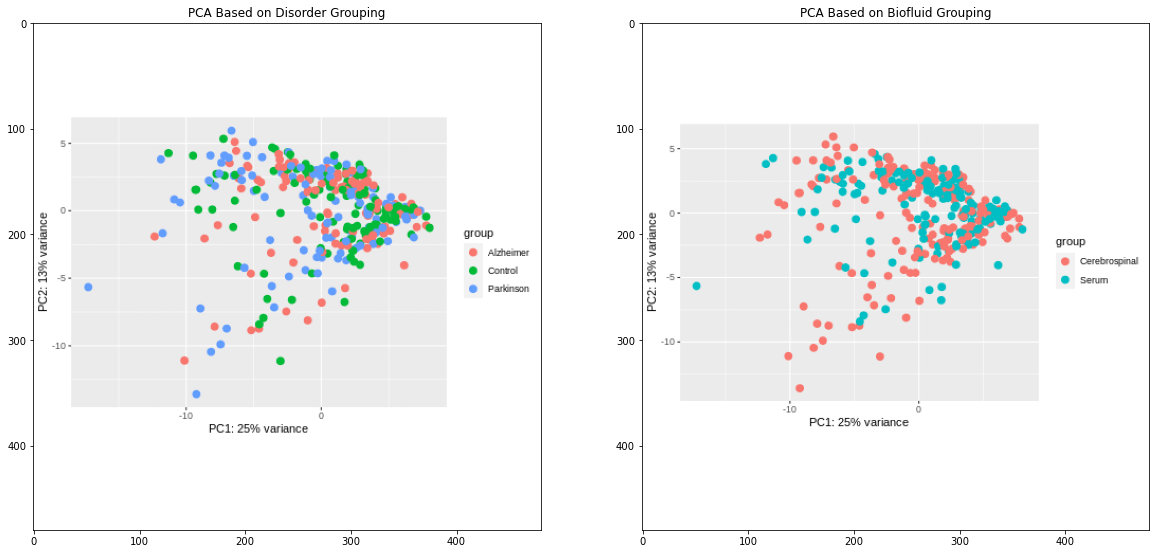

In [85]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/PCAplot_Disorder.png')
img_B = mpimg.imread('../data/out/PCAplot_Biofluid.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

title = ax[0].set_title("PCA Based on Disorder Grouping")
title = ax[1].set_title("PCA Based on Biofluid Grouping")
plt.show()
display(HTML("<b>Figure "+str(figNum)+": (left) PCA based on grouping by disorder. (right) PCA based on grouping by biofluid. </b>"))
figNum += 1

### Missing of Genes
Another analysis we did was with the entire set of counts which not only included miRNA's but also protein coding genes. The combined gene matrix file has approximately 180K genes but most were missing across all samples and are thus not relevant for analysis and compromise quality and performance of the analysis. 

Furthermore, we can identify the top and bottom genes based on a statistic for each gene across the samples that measures the spread against the mean normalized count. Genes which had little spread are likely candidates that might not be important as they do not significantly vary across the samples. The spread statistic we developed was the L1 distance against the mean. The table below shows the top 3 and bottom 3 genes and the spread values. The gene with highest count variance was mir-486a-5p and the bottom ranked gene was mir-2797d. 

In [86]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


df3 = pd.read_csv("../data/out/top_genes.tsv", sep='\t', index_col=0)
df3 = df3.rename({"gene": "Gene"}, axis=1)
df3.Gene = df3.Gene.str.slice(0,15) 
display_side_by_side([df3.iloc[:3,:], df3.iloc[-3:,:]], ['Top Ranked Genes', 'Bottom Ranked Genes'])

display(HTML("<b>Table "+str(tableNum)+": (left) the top ranked genes and their spread. (right) the bottom ranked genes and their spread. </b>"))
tableNum += 1


,Gene,Spread
0,mir-486a-5p,513.508207
1,mir-27b-3p,456.435413
2,mir-143,393.826722
,Gene,Spread
397,mir-148a-3p,1.531662
398,mir-3615,1.531662
399,mir-35g,1.531662


## Data Analysis

The analysis of the data was performed using the same technique in the research paper [1], namely to consider each biofluid separately, and within inside each biofluid to consider each disorder (versus control) separately. This resulted in 4 combinations of analysis computations that were performed.  

With the top genes identified, each of the 2 biofluids ("Serum", "Cerebrospinal fluid") we filtered only the samples for that biofluid and then further break into 2 different tables where we would only include one of the 2 disorders ("Alzheimers", "Parkinsons") plus the control.

The basis of the analysis was the Likelihood Ratio Test (LRT), which is a hypothesis test based on a full and reduced model using the DESeq2 package. The model used the following variables:

- expired_age
- sex
- PMI
- sn_depigmentation
- Braak_Score
- TangleTotal
- Plaque_density
- PlaqueTotal

The outcome variable was Disorder which was not included in the reduced model. The premise of the LRT is to compare models in terms of how they fit the available data by comparing the likelihood scores of the two models [<sup>9</sup>](#fn9) using a statistical test of the goodness-of-fit between two models. The full model with Disorder is compared to a reduced model without Disorder [<sup>9</sup>](#fn9). The output from the analysis was a LRT table which included the baseMean, log2 Fold Change, lfcSE, stat, the pvalue, and adjusted pvalue. The descriptive summary of LRT in biofluid Cerebrospinal fluid for Parkinsons is shown in Table 13 below. 

In [87]:
df4 = pd.read_csv("../data/out/Cerebrospinal/Parkinson/lrt.tsv", sep='\t', index_col=0)
df4.describe().round(3)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
count,400.000,400.000,400.000,400.000,400.000,400.0
mean,2.863,0.028,0.430,0.105,0.871,1.0
std,6.173,0.133,0.020,0.305,0.185,0.0
min,2.022,-0.405,0.285,0.000,0.095,1.0
25%,2.031,-0.002,0.429,0.000,0.827,1.0
50%,2.065,0.004,0.436,0.003,0.960,1.0
75%,2.178,0.046,0.437,0.048,0.996,1.0
max,79.698,0.723,0.540,2.792,1.000,1.0


Table 13: The LRT descriptive summary for biofluid Cerebrospinal fluid for Parkinsons.

## Visualizations

### MA Plot

The LRT data for each of the 4 comparisons was used to generate a 2x2 MA Plot shown in Figure 19 below. This is a scatter plot of the mean of the normalized counts against the log fold change. 
There does not appear to be any highly significant patterns as the data points appear to be within the same band. 

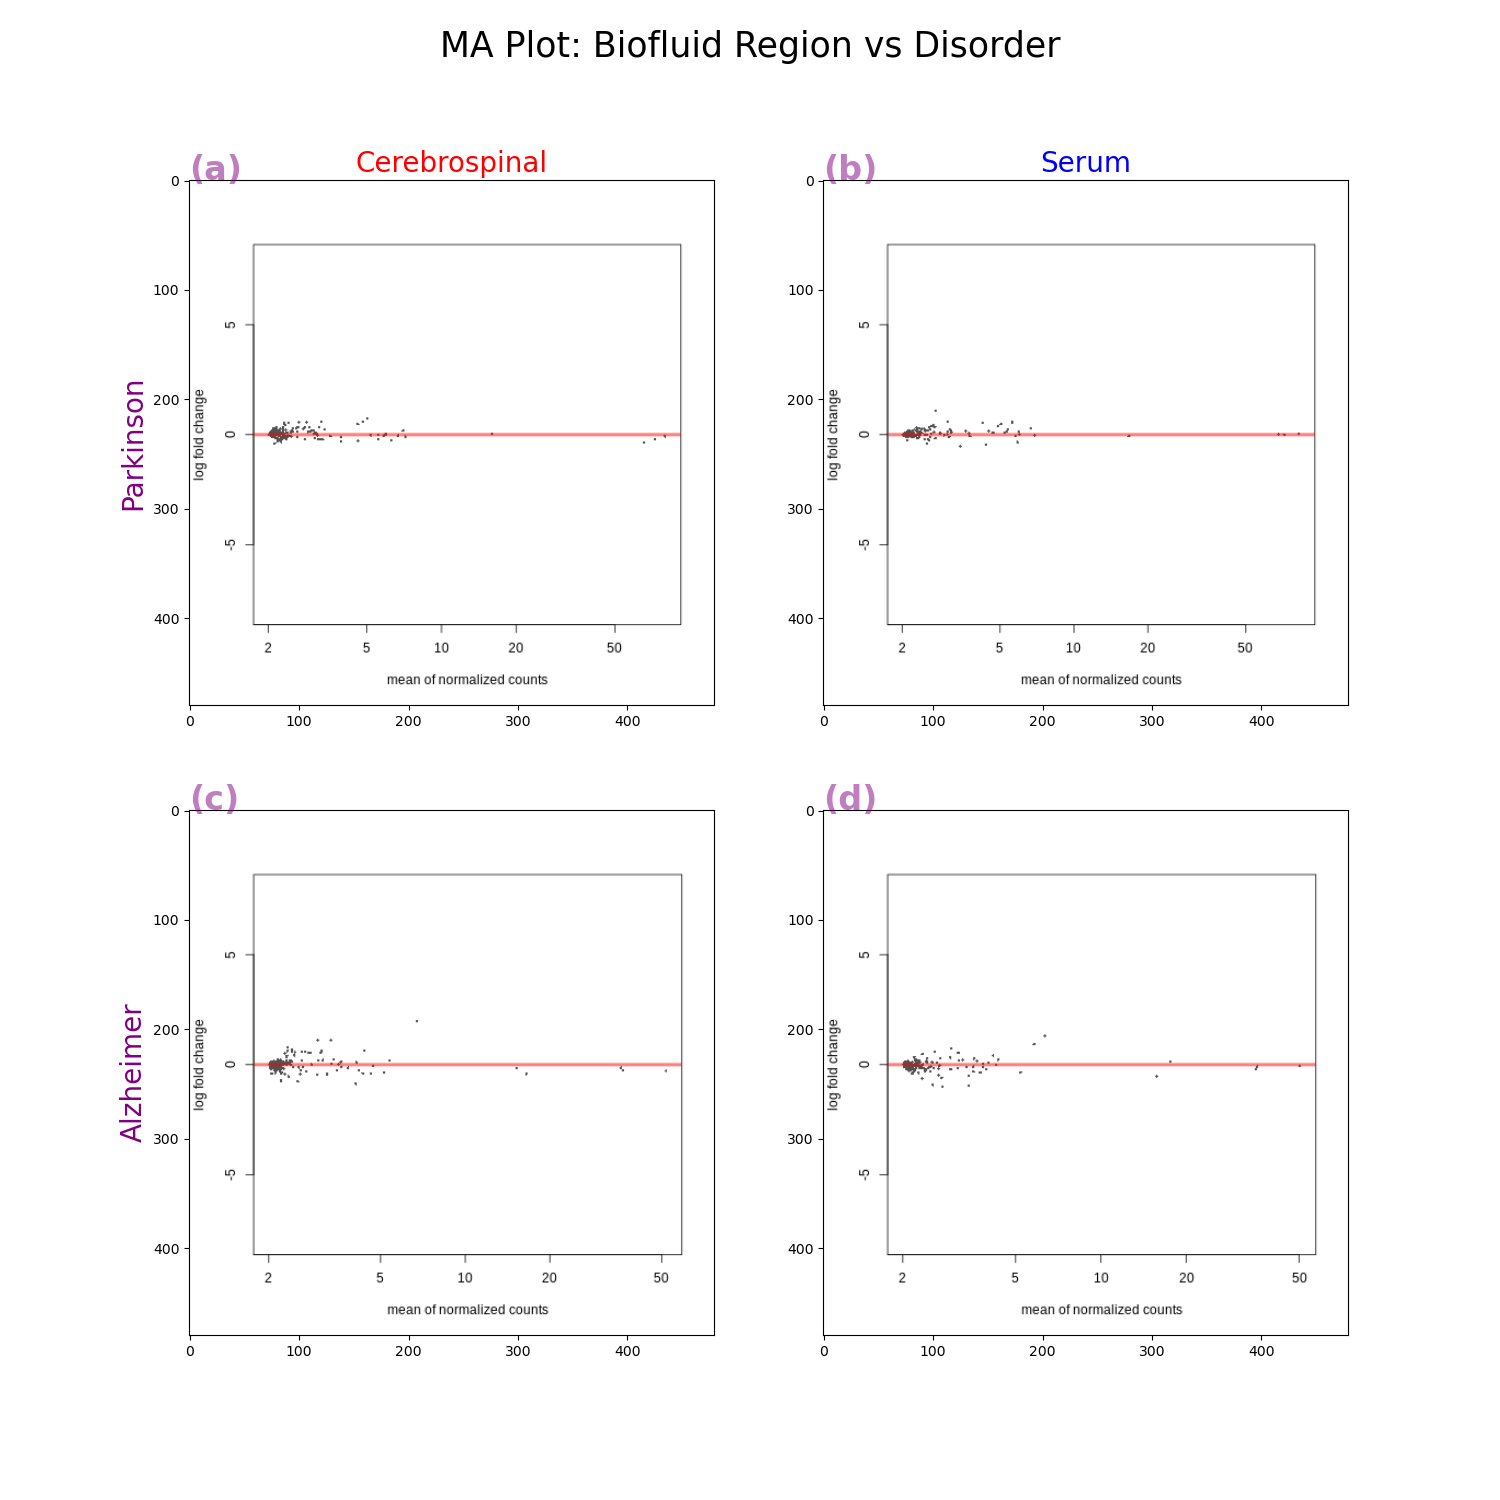

In [88]:
display(Image("../data/out/ma_plot.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": MA Plot for each biofluid versus each disorder. </b>"))
figNum += 1

### Heat Maps

The LRT data for each of the 4 analysis regions was used to generate a 2x2 heatmaps of the top 100 genes is shown in Figure 17 below. Heatmaps allow us to observe specific values of interest across two axis variables in the form of a grid with colored cells[<sup>10</sup>](#fn10). The variables we have used for our axes are the patients and the miRNAs identified across our patient samples, with the main value of interest being the miRNA expression between patients of different disorders. By observing our value of interest, miRNA expression, we can then be able to determine if any patterns or associations exist within our 4 analysis regions. 
It appears that Parkinson's across the biofluids are more similar and Alzheimers across the biofluids are more similar, this is based on the general trends seeing that Parkinson's has less intensity with raw Z-scores closer to 0 and Alzheimers having higher intensity with extreme raw Z-scores -4 and 4. However, one noteable difference is that the placement of the coloring across the heat map is more similar between the biofluids. Meaning that cerebrospinal fluid across Parkinsons and Alzheimers has a more similar color mapping across starting with higher Z-scores (red) then to lower Z-scores (blue). Similarly, serum across Parkinsons and Alzheimers has a more similar color mapping across starting with lower Z-scores (blue) then to higher Z-scores (red). This means that Alzheimers has higher raw Z-scores than Parkinsons, but more importantly the notable similarities in the color scheme across biofluids means that there is some commonality between diseases. 

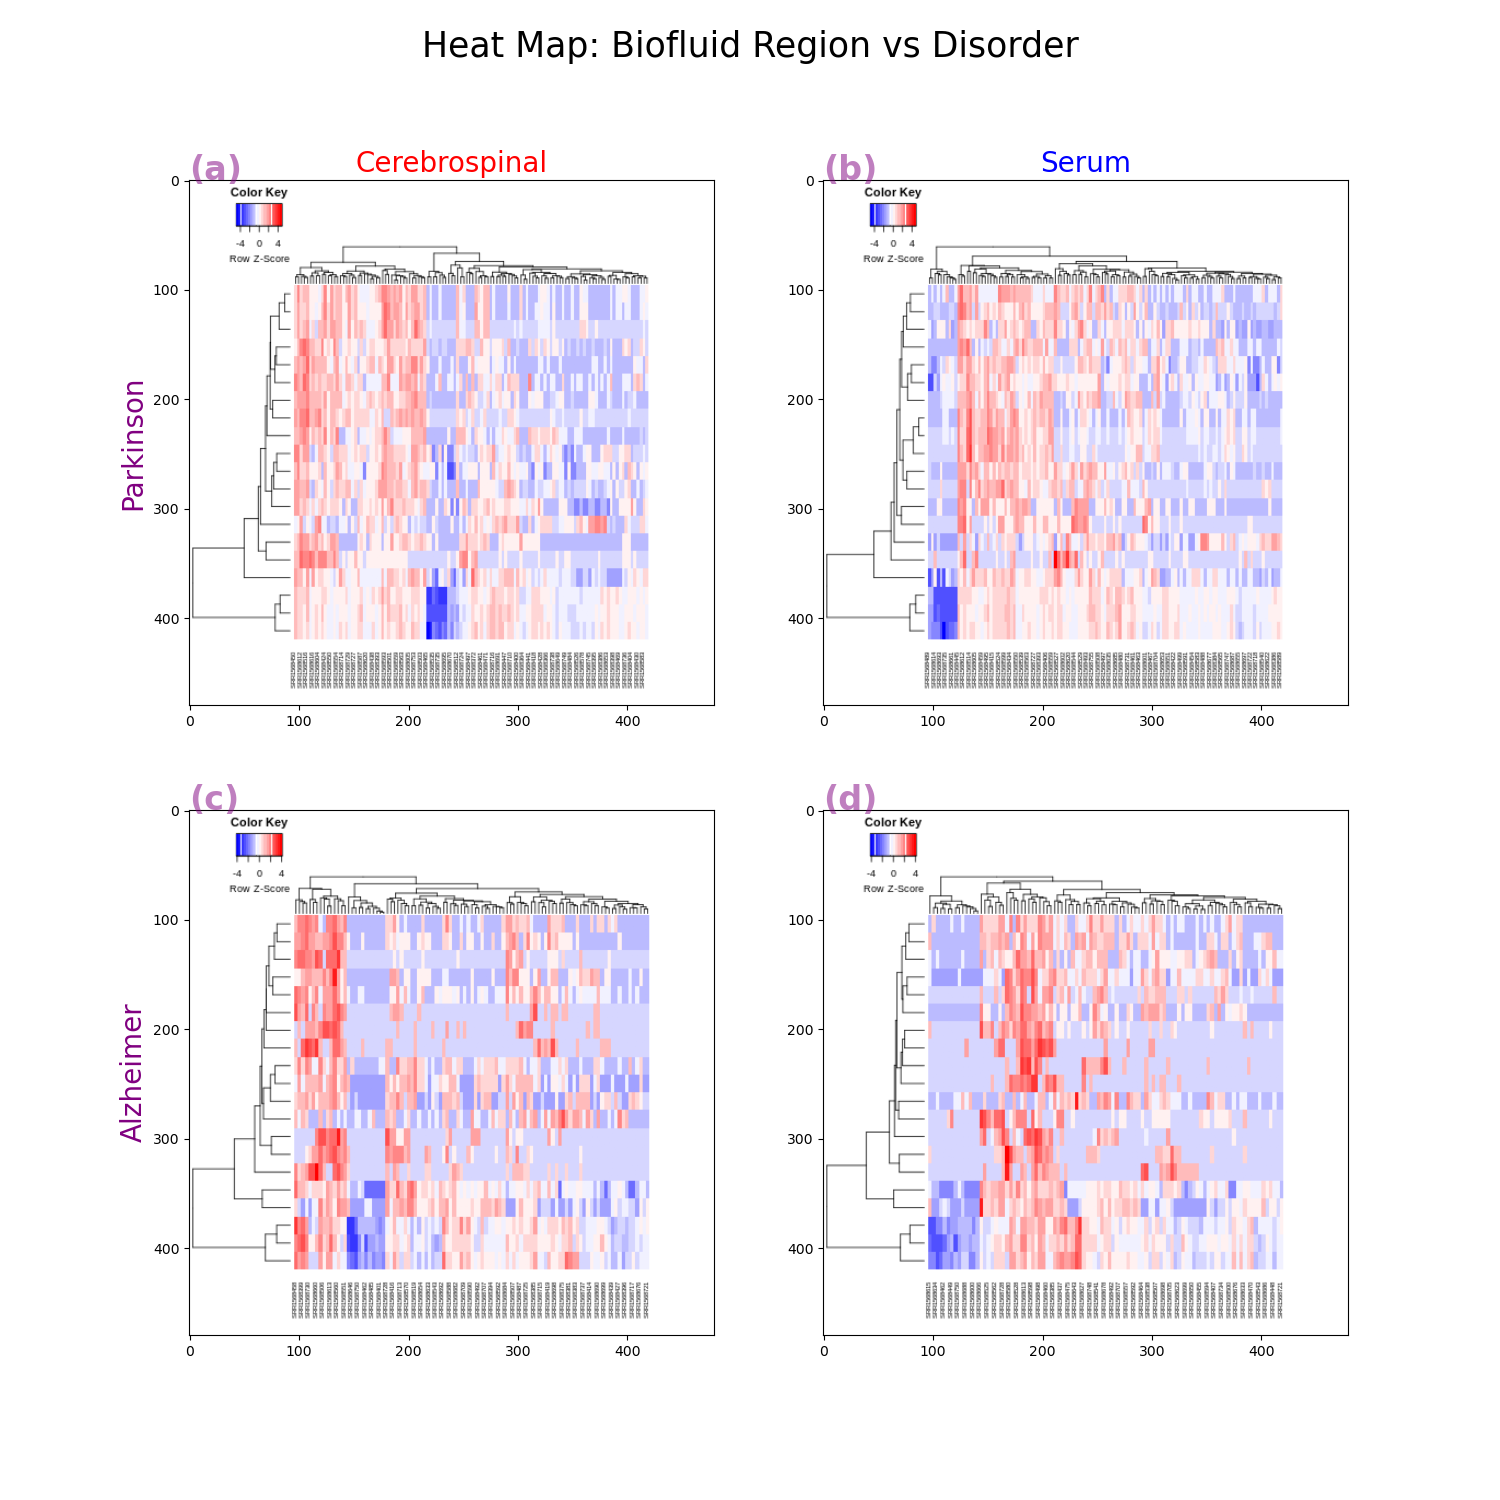

In [89]:
display(Image("../data/out/heat_map.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Top 100 Expressed Gene Heatmap for each biofluid versus each disorder. </b>"))
figNum += 1

### Histograms of case versus control differential expression

We repeat the same visualization in the paper for the distribution of the pvalues for each of the 4 regions shown in Figure 18 below. Each plot below has its peak at 1.0 with a general increase across.
Intrestingly, the charts for cerebrospinal vs Parkinsons and Alzheimers look similar and the charts for serum vs Parkinsons and Alzheimers are more similar. This is significant to note because rather than the disease being more similar across biofluids, it happens to be that the biofluids are more similar across the two disorders.

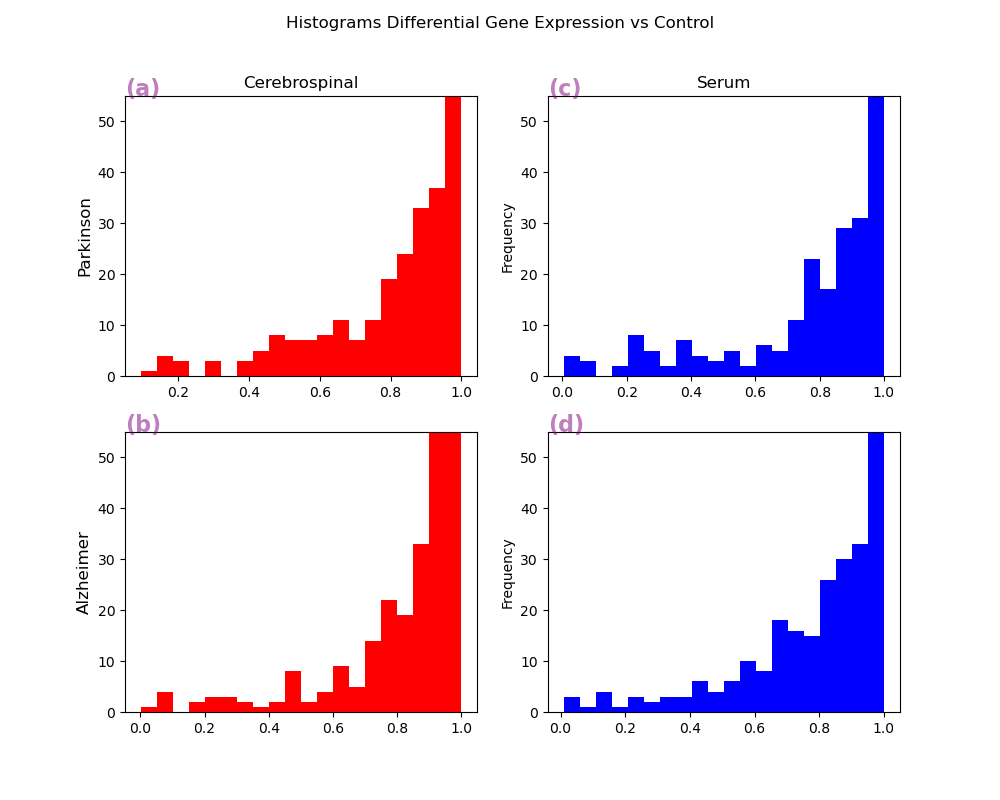

In [90]:
display(Image("../data/out/histogram.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Histogram for each biofluid versus each disorder. </b>"))
figNum += 1

### Venn Diagram of Disorders 

Another visualization performed is a venn diagram that shows overlap of miRNAs differentially expressed between Parkinson (red) and Alzheimer (green). Majority of miRNAs are in Parksinsons with the number 17. There are 13 miRNAs are in Alzheimers. But between the two disorders there are 14 miRNAs shared. Therefore, there is still a good amount of miRNA overlap between the diseases.

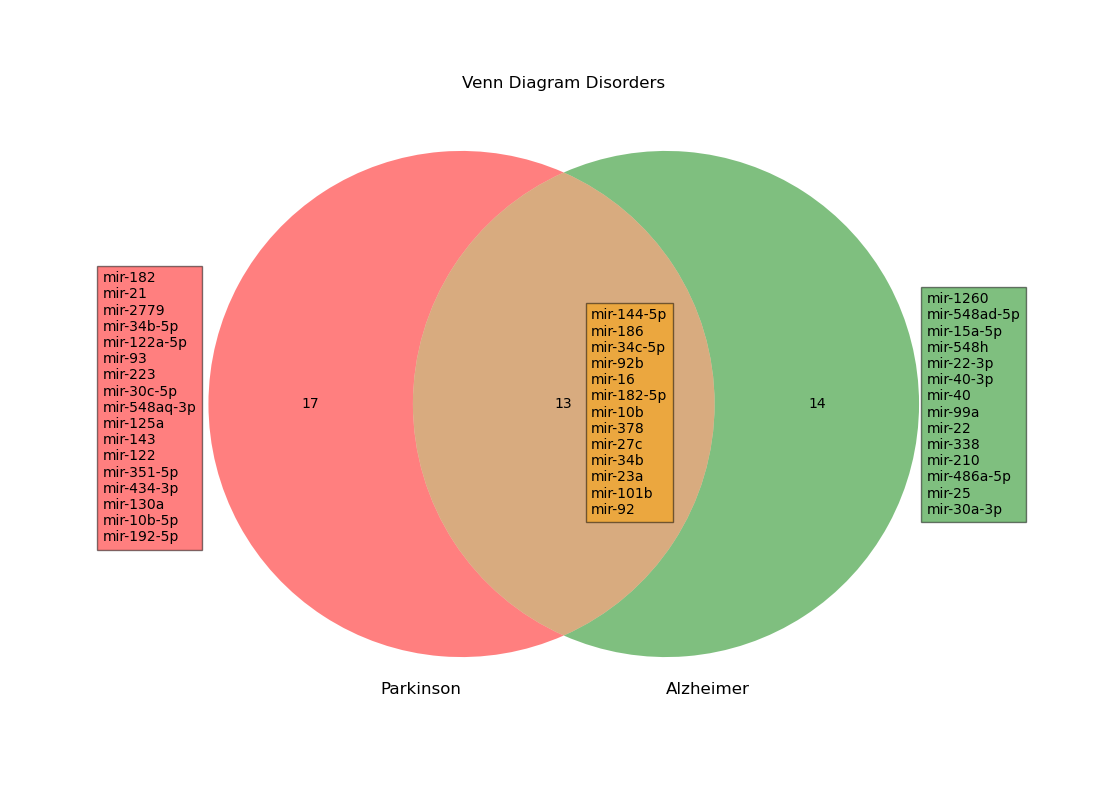

In [91]:
display(Image("../data/out/venn.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Venn Diagram showing miRNA overlap between Parkinson and Alzheimer. </b>"))
figNum += 1

### Spearman correlations of log2 fold gene expression 

We finally recreate the spearman correlation matrix that is pairwise Spearman correlations of log2 fold gene expression changes between each disorder and CTL in each biofluid. The circle sizes are scaled to reflect absolute Spearman correlations. To produce this plot we took the log2 fold gene expressions column from each of the 4 LRT analyses we performed and then use Panda's correlation function to generate a R2 pearson correlation number.

The striking amount of correlation is between Parkinson and Alzheimers in the cerebrospinal fluid region. This is very important as it implies that there is a significant amount of correlation between the two disorders for this biofluid with the highest correlation of 0.30. There is also a significant amount of correlation between Parkinson and Alzheimers in the serum region with a correlation of around 0.27. There is high correlation between the biofluids and the two disorders, especially in the cerebrospinal fluid region.
The results are shown below in Figure 20. 

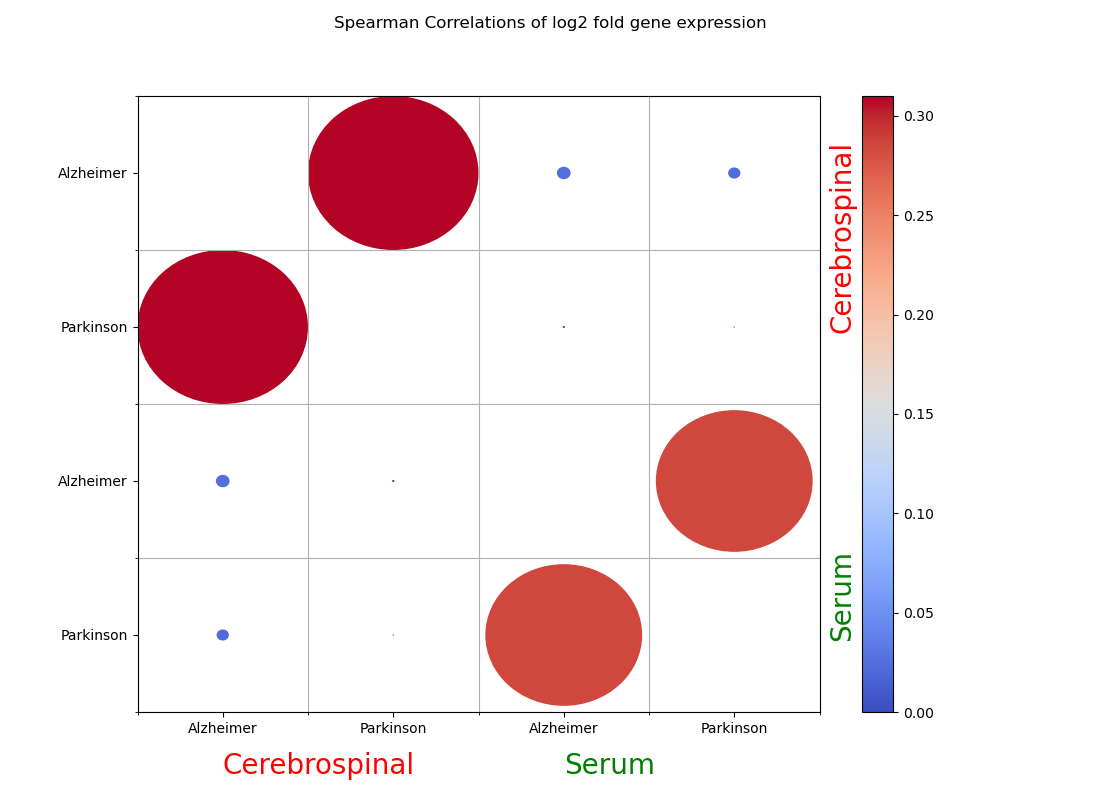

In [92]:
display(Image("../data/out/corrmatrix.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Spearman correlation of log2 fold gene expression for each biofluid against each disorder. </b>"))
figNum += 1

### Volcano Plot
Below is a volcano plot with the two disorders against the two biofluid regions. Volcano plots help to differentiate the down and up regulated miRNA sequences with respect to the control group (healthy patients). It is worthwhile to note that when miRNA are downregulated, this means that there is less miRNA expression - because miRNA regulate mRNA expression, this results in more mRNA expression. mRNA, of course, dictate what proteins are synthesized in the body. In that same vein, when miRNA are upregulated, this means that they regulate mRNA expression at a higher rate, causing less mRNA expression. Chart (a) shows only up regulated miRNAs. Chart (b) shows both down and up regulated miRNAs, with mostly up regulated. Chart (c) shows mostly up regulated miRNAs with few down regulated ones as well. Finally, chart (d) shows a higher amount of down regulated miRNAs with some up regulated ones as well.

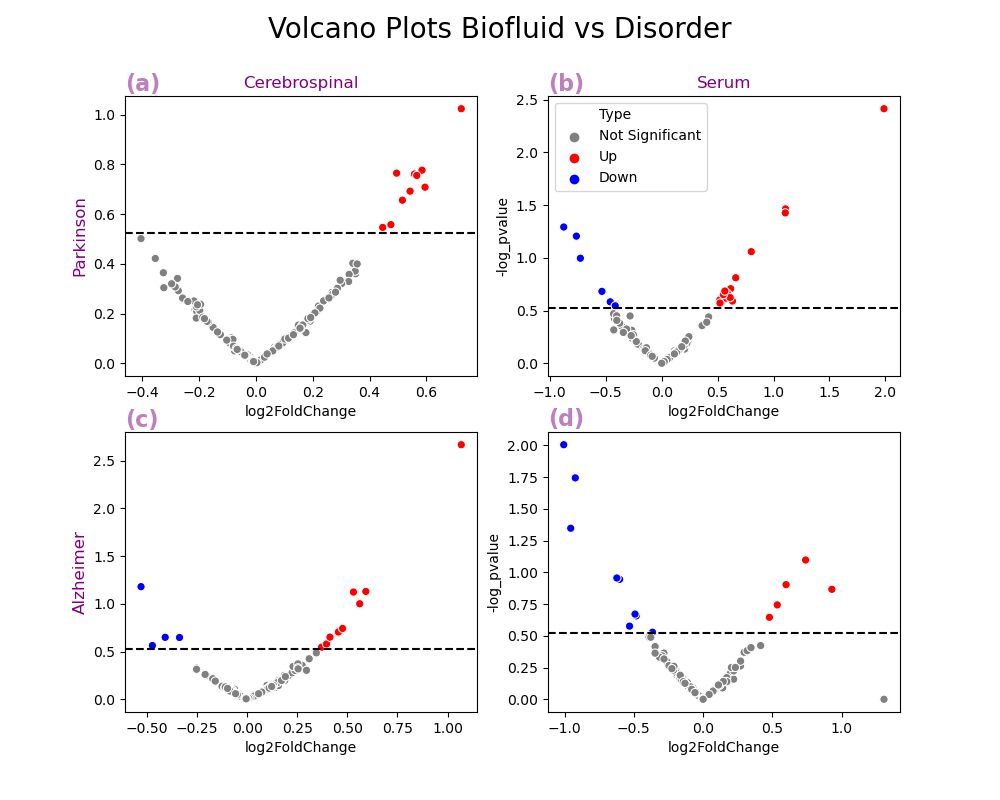

In [93]:
display(Image("../data/out/volcano.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Volcano plot Biofluid versus Disorder. </b>"))
figNum += 1

We decided to take a closer look at the Alzheimer vs Serum Volcano plot. We have labeled the names for both the down and up regulated miRNAs in order to do further analysis.

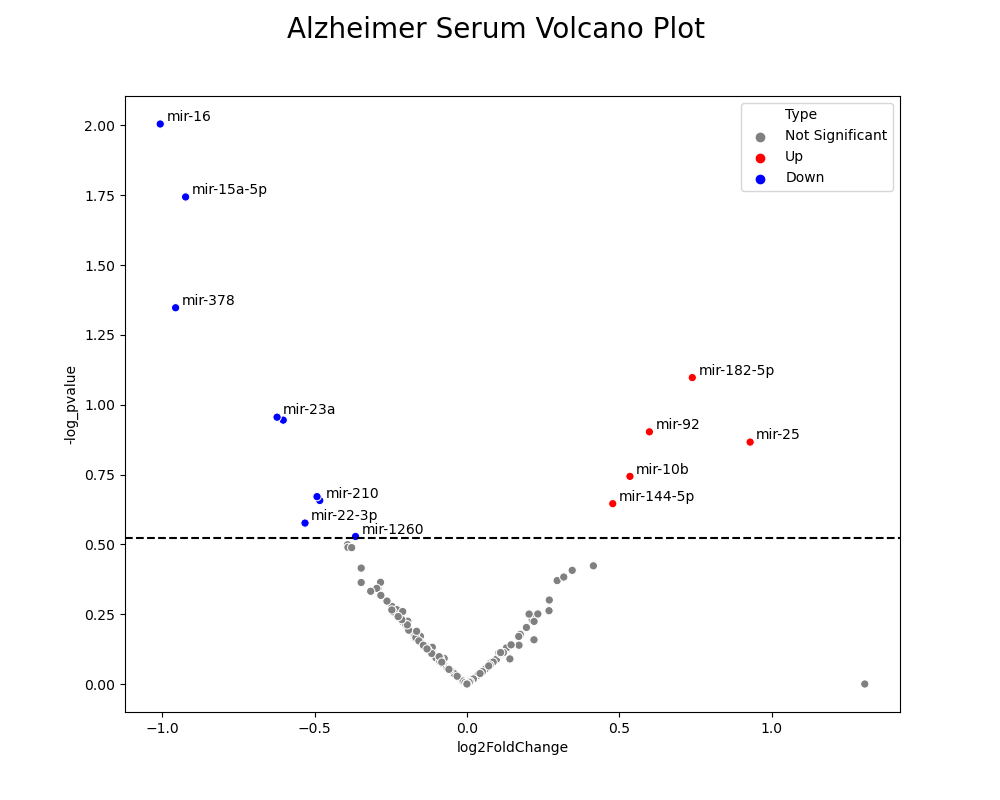

In [94]:
display(Image("../data/out/volcano_details.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Alzheimer vs Serum Volcano plot with miRNAs. </b>"))
figNum += 1

### Mapping the miRNAs of interest to their target mRNAs, and subsequently, to the genes they encode

When mapping certain miRNAs to the specific mRNAs that they regulate the expression of, one issue we ran into was that a miRNA can regulate hundreds of mRNAs. This is because miRNAs only require a small amount of nucleotide matches to be able to latch onto an mRNA and suppress its expression. Therefore, miRNAs can have many target mRNAs. Of course, we are more interested in a small amount of relevant mRNAs, specifically those that encode proteins involved in neurological processes. So, we chose to focus our analysis on the top 3 target mRNAs for each miRNA, ranked in terms of the mRNA's (gene's) "Target Rank" and "Target Score", dictated by miRDB.org.

The mappings are taken from mirdb.org. The site allowed us to search up miRNA sequences and outputs target genes that those miRNA may suppress. As mentioned above, since miRNA can have hundreds of matches, these are just a few matches, some selected because of their high "Target Ranks" and "Target Scores", and others because of past research done by scientists and the proteins' involvement with neurological processes.

In [95]:
pd.set_option('display.max_rows', 20)
pd.read_csv("../data/out/Cerebrospinal/Alzheimer/updown_miRNAs.csv")

,Unnamed: 0,Type,log2FoldChange,-log_pvalue
0,mir-99a,Up,1.068476,2.667435
1,mir-40-3p,Down,-0.529650,1.180250
2,mir-92b,Up,0.592280,1.129815
3,mir-27c,Up,0.530398,1.123541
4,mir-548ad-5p,Up,0.561702,1.001056
5,mir-34b,Up,0.476389,0.742151
6,mir-338,Up,0.455333,0.704723
7,mir-548h,Up,0.413335,0.651008
8,mir-101b,Down,-0.409032,0.649200
9,mir-40,Down,-0.337495,0.647403


#### Mappings 

**mir-99a**: tribbles pseudokinase 2 (TRIB2), kelch repeat and BTB domain containing 8 (KBTBD8), SWI/SNF related, matrix associated, actin dependent regulator of chromatin, subfamily a, member 5 (SMARCA5)

**mir-40-3p**: not found

**mir-92b**: beta-1,3-galactosyltransferase 2 (B3GALT2), mannosidase alpha class 2A member 1 (MAN2A1), 	F-box and WD repeat domain containing 7 (FBXW7), *neurofilament medium (NEFM)*, *phospholipase D1 (PLD1)*, *sortilin related receptor 1 (SORL1)*

**mir-27c**: not found

**mir-548ad-5p**: family with sequence similarity 135 member A (FAM135A), nuclear factor of activated T cells 5 (NFAT5), neuronal growth regulator 1 (NEGR1), tau tubulin kinase 2 (TTBK2), *complement C3b/C4b receptor 1 (Knops blood group) (CR1)*

**mir-34b**: insulin induced gene 1 (INSIG1), protein phosphatase 6 regulatory subunit 3 (PPP6R3), 	furin, paired basic amino acid cleaving enzyme (FURIN), *neuroplastin (NPTN)*

**mir-338**: Cbl proto-oncogene (CBL), 	galectin like (LGALSL), RAB14, member RAS oncogene family (RAB14), neuropilin 1 (NRP1), *phosphatidylinositol binding clathrin assembly protein (PICALM)*

**mir-548h**: 	CREB binding protein (CREBBP), 	ubiquitin conjugating enzyme E2 D1 (UBE2D1), 	zinc finger CCHC-type containing 14 (ZCCHC14), 	*neuron navigator 2 (NAV2)*

**mir-101b**: not found

**mir-40**: not found

**mir-34c-5p**: 	family with sequence similarity 76 member A (FAM76A), 	delta like canonical Notch ligand 1 (DLL1), MDM4, p53 regulator (MDM4), *neuron navigator 1 (NAV1)*, 	neuron navigator 3 (NAV3), microtubule associated protein tau (MAPT)

**mir-486a-5p**: not found

**mir-30a-3p**: cell division cycle 73 (CDC73), zinc finger E-box binding homeobox 2 (ZEB2), 	nuclear FMR1 interacting protein 2 (NUFIP2)

Based on prior research, Alzheimer's disease has primarily been linked with a protein called apolipoprotein E (APOE) (https://medlineplus.gov/genetics/gene/apoe/#conditions). Researchers have found that the presence of this particular gene has been associated with the formation of amyloid plaques (the presence of which we studied and incorporated into our DESeq2 model). These protein clumps "clog up" the brain and lead to the death of nerve cells. Unfortunately, the mapping of the differentially expressed miRNA in the CSF of Alzheimer's patients did not uncover this protein. Another gene commonly linked with AD is the tau protein, which contributes to the "tangles" in Alzheimer's brains (we also studied this in our analysis). In this vein, some of the genes that were found to be affected by one of the up-regulated miRNAs were tau tubulin kinase 2 (TTBK2) and microtubule associated protein tau (MAPT). These genes contribute to making the protein that forms the tau tangles in the brain. However, there are other proteins that have been found to be related to the onset of Alzheimer's (https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/in-depth/alzheimers-genes/art-20046552). One such gene was complement C3b/C4b receptor 1 (CR1). The upregulated miRNA represses the expression of this gene, which decreases the production a protein in the brain that is partly responsible for controlling brain inflammation. The absence of this protein can result in inflammation, a possible cause of Alzheimer's. Another such gene is the one that encodes phosphatidylinositol binding clathrin assembly protein (PICALM), which contributes to the process of neurons communicating signals to each other and ensuring that the right communication happens in order for the body to function properly, as well as the process of memory formation (mayo clinic article). The absence of this protein can negatively affect these processes. There are also neurological proteins that are affected by the up-regulation of miRNA. For example, the amount of neuroplastin available in the brain is affected by some miRNA. Neuroplastin is a protein that is important in neuron and synaptic functions; in other words, they are significant in the process of cells communicating with each other (https://pubmed.ncbi.nlm.nih.gov/25040546/). 

In [96]:
pd.read_csv("../data/out/Cerebrospinal/Parkinson/updown_miRNAs.csv")

,Unnamed: 0,Type,log2FoldChange,-log_pvalue
0,mir-34b,Up,0.722977,1.023605
1,mir-34c-5p,Up,0.584796,0.776372
2,mir-27c,Up,0.495344,0.764454
3,mir-434-3p,Up,0.558104,0.760882
4,mir-92b,Up,0.566194,0.755235
5,mir-130a,Up,0.595353,0.708097
6,mir-351-5p,Up,0.542760,0.692046
7,mir-10b,Up,0.515659,0.655791
8,mir-34b-5p,Up,0.475180,0.557489
9,mir-23a,Up,0.446270,0.546405


#### Mappings

**mir-34b**: insulin induced gene 1 (INSIG1), 	protein phosphatase 6 regulatory subunit 3 (PPP6R3), 	furin, paired basic amino acid cleaving enzyme (FURIN), *neuroplastin (NPTN)*

**mir-34c-5p**: family with sequence similarity 76 member A (FAM76A),  delta like canonical Notch ligand 1 (DLL1), 	MDM4, p53 regulator (MDM4), *neuron navigator 1 (NAV1)*

**mir-27c**: not found 

**mir-434-3p**: not found

**mir-92b**: 	beta-1,3-galactosyltransferase 2 (B3GALT2), 	mannosidase alpha class 2A member 1 (MAN2A1), 	F-box and WD repeat domain containing 7 (FBXW7), *neurofilament medium (NEFM)*

**mir-130a**: gap junction protein alpha 1 (GJA1), 	cytoplasmic polyadenylation element binding protein 1 (CPEB1), SKI/DACH domain containing 1 (SKIDA1), *leucine rich repeat kinase 2 (LRRK2)*

**mir-351-5p**: not found

**mir-10b**: cell adhesion molecule 2 (CADM2), 	transcription factor AP-2 gamma (TFAP2C), CCR4-NOT transcription complex subunit 6 (CNOT6)

**mir-34b-5p**: teneurin transmembrane protein 1 (TENM1), 	ELMO domain containing 1 (ELMOD1), 	regulatory factor X3 (RFX3), *parkin RBR E3 ubiquitin protein ligase (PRKN)*

**mir-23a**: zinc finger protein 99 (ZNF9), semaphorin 6D (SEMA6D), family with sequence similarity 234 member B (FAM234B)

Based on prior research, researchers have pinpointed some possible genes that, coupled with family history, can mutate and cause Parkinson's disease (https://medlineplus.gov/genetics/condition/parkinson-disease/#causes). We were able to find miRNA that affected the expression of some of these genes, and consequently the proteins that they help to create. One such gene is leucine rich repeat kinase 2 (LRRK2). This gene encodes a protein called dardarin, which plays a big role in biological processes that require inter-protein interaction, like the transmitting of signals between neurons or assembling a cell's cytoskeleton (its physical framework) (https://medlineplus.gov/genetics/gene/lrrk2/#conditions). Another protein found to be related to Parkinson's is parkin RBR E3 ubiquitin protein ligase (PRKN). This gene encodes the protein parkin, which helps in the cell by tagging unneeded proteins with markers called ubiquitin. This lets other parts of the cell know that those proteins are unneeded, so they are properly disposed in structures called proteasomes. With the absence of parkin, this system is compromised, and the build-up of unnecessary proteins may lead to issues that cause physical movement and balance problems associated with PD. The failure of the ubiquitin-proteasome system can also affect normal cell activities and the cells themselves, specifically those that produce dopamine. Decrease of dopamine production is a tell-tale sign of Parkinson's (https://medlineplus.gov/genetics/gene/prkn/#conditions). One neurologically-related protein that we found to be affected by miRNA expression was neurofilament medium (NEFM). The neurofilament medium protein encodes the protein neurofilament, which is used by cells to mark neurons that are damaged. If this system is affected, there would be no way to distinguish between working and damaged neurons, gravely affecting neuronal activity (https://www.ncbi.nlm.nih.gov/gene/4741). 

In [97]:
pd.read_csv("../data/out/Serum/Alzheimer/updown_miRNAs.csv")

,Unnamed: 0,Type,log2FoldChange,-log_pvalue
0,mir-16,Down,-1.006115,2.005127
1,mir-15a-5p,Down,-0.922835,1.743917
2,mir-378,Down,-0.955715,1.347237
3,mir-182-5p,Up,0.739354,1.097146
4,mir-23a,Down,-0.622807,0.955343
5,mir-186,Down,-0.602617,0.944766
6,mir-92,Up,0.598591,0.902923
7,mir-25,Up,0.929064,0.866180
8,mir-10b,Up,0.534783,0.743404
9,mir-22,Down,-0.491724,0.670908


#### Mappings

**mir-16**: pappalysin 1 (PAPPA), fatty acid synthase (FASN), unc-80 homolog, NALCN channel complex subunit (UNC80), *clusterin (CLU)*, *triggering receptor expressed on myeloid cells 1 (TREM1)*, *neurofibromin 1 (NF1)*

**mir-15a-5p**: pappalysin 1 (PAPPA), fatty acid synthase (FASN), 	unc-80 homolog, NALCN channel complex subunit (UNC80), *neuritin 1 (NRN1)*, *neuropilin 2 (NRP2)*

**mir-378**: ubinuclein 2 (UBN2), vestigial like family member 3 (VGLL3), M-phase specific PLK1 interacting protein (MPLKIP)

**mir-182-5p**: protein kinase cAMP-activated catalytic subunit beta (PRKACB), regulator of G protein signaling 17 (RGS17), basonuclin 2 (BNC2)

**mir-23a**: zinc finger protein 99 (ZNF99), semaphorin 6D (SEMA6D), family with sequence similarity 234 member B (FAM234B), *neuroligin 4 X-linked (NLGN4X)*

**mir-186**: RUN and FYVE domain containing 3 (RUFY3), zinc finger CCCH-type containing 11A (ZC3H11A), 	zinc finger protein 644 (ZNF644),  neuronal growth regulator 1 (NEGR1)

**mir-92**: beta-1,3-galactosyltransferase 2 (B3GALT2), mannosidase alpha class 2A member 1 (MAN2A1), F-box and WD repeat domain containing 7 (FBXW7), *sortilin related receptor 1 (SORL1)*

**mir-25**: CD69 molecule (CD69), solute carrier family 12 member 5 (SLC12A5), mannosidase alpha class 2A member 1 (MAN2A1)

**mir-10b**: cell adhesion molecule 2 (CADM2), transcription factor AP-2 gamma (TFAP2C), CCR4-NOT transcription complex subunit 6 (CNOT6), 	*brain derived neurotrophic factor (BNDF)*

**mir-22**:	glutamate metabotropic receptor 5 (GRM5), fucosyltransferase 9 (FUT9), *neuroepithelial cell transforming 1 (NET1)*

**mir-210**: insulin like growth factor 2 (IGF2), iron-sulfur cluster assembly enzyme (ISCU), galanin receptor 2 (GALR2), brain derived neurotrophic factor (BDNF), *neuronal pentraxin 1 (NPTX1)*

**mir-144-5p**:	zinc finger protein 292 (ZNF292), ATPase H+ transporting V1 subunit C1 (ATP6V1C1), HIC ZBTB transcriptional repressor 1 (HIC1), neurotrophic receptor tyrosine kinase 2 (NTRK2), *neuregulin 3 (NRG3)*

**mir-22-3p**: glutamate metabotropic receptor 5 (GRM5), fucosyltransferase 9 (FUT9), *neuroepithelial cell transforming 1 (NET1)*

**mir-1260**: zinc finger protein 268 (ZNF268), zinc finger protein 763 (ZNF763), cutaneous T cell lymphoma-associated antigen 1 (CTAGE1), *complement C3b/C4b receptor 1 (Knops blood group) (CR1)*

As mentioned above when inspecting Alzheimer's samples from CSF, researchers have already pinpointed some genes that have a likely connection with Alzheimer's. One of these genes is the triggering receptor expressed on myeloid cells 1 (TREM1). Receptors on myeloid cells are responsible for controlling inflammation and neurological development (https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-014-0293-z#:~:text=The%20Triggering%20Receptors%20Expressed%20on,neurological%20development%20and%20blood%20coagulation.&text=In%20the%20intestine%2C%20TREM%2D1,bowel%20disease%20(IBD)%20pathogenesis.). Inflammation, especially in the brain, as mentioned earlier, is a tell-tale sign of Alzheimer's. Clusterin (CLU) is a gene that helps to regulate amyloid-beta amounts in the brain - these, as we know, make up the plaque structures that are found in Alzheimer's brains. An imbalance in the production and movement of amyloid-beta is then crucial to the development of Alzheimer's (https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/in-depth/alzheimers-genes/art-20046552). Another such gene is sortilin related receptor 1 (SORL1). SORL1 is a gene that is involved in the production of amyloid-beta peptides, which are the same plaque structures that are found in the brain of Alzheimer's patients (https://www.uniprot.org/uniprot/Q92673). There were also neurologically-related genes that were found to be affected by the differentially expressed miRNA. For example, the count of brain derived neurotrophic factor (BDNF) was found to be decreased by an up-regulated miRNA. The BDNF protein is largely reponsible for promoting the growth of and dealing with the maintenance of nerve cells (https://medlineplus.gov/genetics/gene/bdnf/#:~:text=The%20BDNF%20gene%20provides%20instructions,and%20maintenance%20of%20these%20cells.). One target gene of many miRNA in this group was neuregulin 3 (NRG3), which is a group of signaling proteins that helps to oversee cellular functions of neuronal systems, like survival, proliferation, and differentiation of nerve cells (https://www.sciencedirect.com/topics/veterinary-science-and-veterinary-medicine/neuregulin#:~:text=Neuregulins%20(NRGs)%20are%20a%20family,neuronal%20and%20non%2Dneural%20systems.). Neuronal pentraxin 1 (NP1) is another gene that was affected by miRNA. The miRNA that targeted NP1 was actually found to be down-regulated, which increases the production of NP1; NP1 is involved in the process of inducing neuronal cell death, and a surplus of NP1 could result in more neurons being destroyed prematurely (https://www.jneurosci.org/content/35/14/5504#:~:text=Neuronal%20pentraxin%201%20(NP1)%20is,et%20al.%2C%202001).&text=In%20contrast%20to%20NP2%2C%20NP1,et%20al.%2C%202001).). 

In [98]:
pd.set_option('display.max_rows', 25)
pd.read_csv("../data/out/Serum/Parkinson/updown_miRNAs.csv")

,Unnamed: 0,Type,log2FoldChange,-log_pvalue
0,mir-192-5p,Up,1.987334,2.412864
1,mir-182-5p,Up,1.106859,1.463374
2,mir-93,Up,1.104689,1.425775
3,mir-143,Down,-0.875965,1.291720
4,mir-10b-5p,Down,-0.763093,1.205186
5,mir-144-5p,Up,0.800832,1.057860
6,mir-125a,Down,-0.727192,0.995720
7,mir-182,Up,0.661768,0.810613
8,mir-21,Up,0.616150,0.707095
9,mir-92,Up,0.564453,0.684278


#### Mappings

**mir-192-5p**: NIPA like domain containing 1 (NIPAL1), basic helix-loop-helix family member e22 (BHLHE22), protein kinase D3 (PRKD3), *neurofilament light (NEFL)*

**mir-182-5p**: protein kinase cAMP-activated catalytic subunit beta (PRKACB), 	regulator of G protein signaling 17 (RGS17), basonuclin 2 (BNC2), *neurocalcin delta (NCALD)*

**mir-93**: ectonucleotide pyrophosphatase/phosphodiesterase 5 (putative) (ENPP5), 	FYVE and coiled-coil domain containing 1 (FYCO1), dynein cytoplasmic 1 light intermediate chain 2 (DYNC1LI2)

**mir-143**: ABL proto-oncogene 2, non-receptor tyrosine kinase (ABL2), vasohibin 1 (VASH1), DENN domain containing 1B (DENND1B)

**mir-10b-5p**: cell adhesion molecule 2 (CADM2), transcription factor AP-2 gamma (TFAP2C), CCR4-NOT transcription complex subunit 6 (CNOT6), brain derived neurotrophic factor (BDNF)

**mir-144-5p**: zinc finger protein 292 (ZNF292), ATPase H+ transporting V1 subunit C1 (ATP6V1C1), 	HIC ZBTB transcriptional repressor 1 (HIC1), neuregulin 3 (NRG3)

**mir-125a**: DTW domain containing 1 (DTWD1), BCL2 family apoptosis regulator BOK (BOK), BRCA1, DNA repair associated (BRCA), 	*neuronal vesicle trafficking associated 2*

**mir-182**: protein kinase cAMP-activated catalytic subunit beta (PRKACB), regulator of G protein signaling 17 (RGS17), basonuclin 2 (BNC2)

**mir-21**:	YOD1 deubiquitinase (YOD1), Fas ligand (FASLG), PR/SET domain 11 (PRDM11), *neurotrophin 3* (NTF3)

**mir-92**: folliculin interacting protein 1 (FNIP1), CD69 molecule (CD69), G3BP stress granule assembly factor 2 (G3BP2), neurofilament medium (NEFM)

**mir-92b**: beta-1,3-galactosyltransferase 2 (B3GALT2), mannosidase alpha class 2A member 1 (MAN2A1), F-box and WD repeat domain containing 7 (FBXW7),	*neurofilament medium (NEFM)*

**mir-30c-5p**:	twinfilin actin binding protein 1 (TWF1), UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosaminyltransferase 5 (B3GNT5), embryonic ectoderm development (EED), *neural cell adhesion molecule 1 (NCAM1)*, *leucine rich repeat kinase 2 (LRRK2)*

**mir-548aq-3p**: polyhomeotic homolog 3 (PHC3), CREB3 regulatory factor (CREBRF), protein tyrosine phosphatase, receptor type K (PTPRK), *synuclein alpha (SNCA)*

**mir-186**: RUN and FYVE domain containing 3 (RUFY3), zinc finger CCCH-type containing 11A (ZC3H11A), zinc finger protein 644 (ZNF644), *neuronal growth regulator 1 (NEGR1)* 

**mir-378**: ubinuclein 2 (UBN2), vestigial like family member 3 (VGLL3), M-phase specific PLK1 interacting protein (MPLKIP)

**mir-16**: pappalysin 1 (PAPPA), fatty acid synthase (FASN), unc-80 homolog, NALCN channel complex subunit (UNC80), clusterin (CLU), triggering receptor expressed on myeloid cells 1 (TREM1), neurofibromin 1 (NF1)

**mir-122a-5p**: not found

**mir-101b**: not found

**mir-122**: heterogeneous nuclear ribonucleoprotein U (HNRNPU), cytoplasmic polyadenylation element binding protein 1 (CPEB1), CD40 ligand (CD40LG)

**mir-10b**: cell adhesion molecule 2 (CADM2), transcription factor AP-2 gamma (TFAP2C), CCR4-NOT transcription complex subunit 6 (CNOT6)

**mir-223**: F-box and WD repeat domain containing 7 (FBXW7), SP3 transcription factor (SP3), *synuclein alpha (SNCA)*, *neuron derived neurotrophic factor (NDNF)*

**mir-2779**: not found

In this group of data/results, something that stood out was the overlap of many proteins with the Alzheimer's in serum group, as well as the two CSF groups. Proteins like neurofilament, neuregulin, BDNF, and neuronal growth regulators have been affected by up- and down-regulated miRNAs in both the CSF and serum groups for the two disease conditions. One new protein that seems to be related to Parkinson's and serum specifically, though, is neurocalcin delta (NCALD). A decrease in NCALD has been shown to protect against spinal muscular atrophy, a symptom tangentially related to the symptoms of Parkinson's (https://www.frontiersin.org/articles/10.3389/fnmol.2019.00019/full). Another target protein that has also been pinpointed by researchers in the past to be connected to Parkinson's is synuclein alpha (SNCA). This is one of the most common proteins linked to Parkinson's - mutations of this protein can disrupt cell homeostasis and neuron death (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3281589/). 

## Overlapping miRNA (from Figure __)

**mir-16**: mir-16: pappalysin 1 (PAPPA), fatty acid synthase (FASN), unc-80 homolog, NALCN channel complex subunit (UNC80), *clusterin (CLU)*, *triggering receptor expressed on myeloid cells 1 (TREM1)*, *leucine rich repeat kinase 1 (LRRK1)

**mir-92b**: beta-1,3-galactosyltransferase 2 (B3GALT2), mannosidase alpha class 2A member 1 (MAN2A1), F-box and WD repeat domain containing 7 (FBXW7), *neurofilament medium (NEFM)*

**mir-34b**: insulin induced gene 1 (INSIG1), protein phosphatase 6 regulatory subunit 3 (PPP6R3), furin, paired basic amino acid cleaving enzyme (FURIN), *neuroplastin (NPTN)*

**mir-378**: ubinuclein 2 (UBN2), vestigial like family member 3 (VGLL3), M-phase specific PLK1 interacting protein (MPLKIP)

**mir-101b**: not found

**mir-182-5p**: protein kinase cAMP-activated catalytic subunit beta (PRKACB), regulator of G protein signaling 17 (RGS17), basonuclin 2 (BNC2), *neurocalcin delta (NCALD)*

**mir-34c-5p**: family with sequence similarity 76 member A (FAM76A), delta like canonical Notch ligand 1 (DLL1), MDM4, p53 regulator (MDM4), *neuron navigator 1 (NAV1)*, *neuron navigator 3 (NAV3)*, *microtubule associated protein tau (MAPT)*

**mir-10b**: cell adhesion molecule 2 (CADM2), transcription factor AP-2 gamma (TFAP2C), CCR4-NOT transcription complex subunit 6 (CNOT6), *brain derived neurotrophic factor (BNDF)*

**mir-186**: RUN and FYVE domain containing 3 (RUFY3), zinc finger CCCH-type containing 11A (ZC3H11A), zinc finger protein 644 (ZNF644), *neuronal growth regulator 1 (NEGR1)*

**mir-23a**: zinc finger protein 99 (ZNF99), semaphorin 6D (SEMA6D), family with sequence similarity 234 member B (FAM234B), *neuroligin 4 X-linked (NLGN4X)*

**mir-27c**: not found

**mir-144-5p**: zinc finger protein 292 (ZNF292), ATPase H+ transporting V1 subunit C1 (ATP6V1C1), HIC ZBTB transcriptional repressor 1 (HIC1), *neuregulin 3 (NRG3)*

We found that the overlapping miRNA that are differentially expressed are all up-regulated, meaning that they restrict the amounts of the target proteins listed above. These overlapping miRNA are the central focus of our research project. We have discussed the importance of many of these genes in the previous sections for the individual conditions and data sources, and the neural functions that they contribute are all affected in the development of both Alzheimer's and Parkinson's diseases. Specifically for Alzheimer's, for example, clusterin helps to regulate the processing of amyloid-beta structures, which make up plaques in Alzheimer's brains. Another Alzheimer's-focused gene is TREM1, which encodes receptors on myeloid cells. These receptors are responsible for controlling brain inflammation, which is a tell-tale sign of Alzheimer's. Specifically for Parkinson's, LRRK1 plays a big role in biological processes that require inter-protein interaction, like the transmitting of signals between neurons - the repression of this gene can play a big factor in the movement problems of Parkinson's patients. What is most interesting, however, are the overlapping miRNA that seem to affect both Alzheimer's and Parkinson's disease patients, particularly their brains. The decrease in the amounts of the following proteins can affect the brain function of those affected. For example, neurofilament medium encodes neurofilament, the protein that is used by cells to mark neurons that are damaged. Neuroplastin is a protein that is important in neuron and synaptic functions. Neurocalcin delta has been shown to protect against spinal muscular atrophy, a symptom tangentially related to the symptoms of Parkinson's. The BDNF protein is largely reponsible for promoting the growth of and dealing with the maintenance of nerve cells. Finally, neuregulin 3 (NRG3), which is a group of signaling proteins that helps to oversee cellular functions of neuronal systems, like survival, proliferation, and differentiation of nerve cells.

## Conclusion

Our goal for this study was to find genetic overlapping in Alzheimer's and Parkinson's in order to guide future research with key miRNA that are present in both diseases. Through our volcano visualization we identified up and down-regulated miRNAs in both diseases across the cerebrospinal and serum biofluids. Additionally, our venn diagram's overlap helped to indicate which miRNAs are shared between the diseases. We mapped all the up-regulated, down-regulated and overlapping miRNAs to the top 3 target mRNAs that they are binding to (ranked in terms of the mRNA's (gene's) "Target Rank" and "Target Score"). With careful analysis we discovered that the overlapping miRNA's were all up-regulated, meaning the miRNAs are restricting the amounts of target proteins that we found. 

The important target proteins we have found in Alzheimer's are:<br>
clusterin (CLU) <br>
triggering receptor expressed on myeloid cells 1 (TREM1)<br>
microtubule associated protein tau (MAPT)<br>
These have all been linked as key to Alzheimer's Disease by previous studies.

The important target protein we have found in Parkinson's is:<br>
leucine rich repeat kinase 1 (LRRK1)<br>
This has been linked as key to Parkinson's Disease by previous studies.

However, the most significant proteins we have found are listed below, these have not to our knowledge been identified yet in other studies. These are common to both Alzheimer's and Parkinson's diseases:<br>
neurofilament medium (NEFM)<br>
neuroplastin (NPTN)<br>
neurocalcin delta (NCALD)<br>
brain derived neurotrophic factor (BNDF)<br>
neuregulin (NRG3)<br>

We hope that these significant proteins that we found as genetically overlapped in the cerebrospinal and serum biofluid regions will help future researchers and scientists to gain a better understanding at how these two diseases are linked and that future progress can be made in order to target these proteins to inhibit or lessen the effects of both Alzheimer's and Parkinson's Diseases. 

# Appendix

## Project Targets

### Running the project

•	To install the dependencies, run the following command from the root directory of the project: 

    pip install -r requirements.txt


### target: data
•	To process the data, from the root project directory run the command:

    python3 run.py data

•   The data pipeline step takes the .fastq compressed files as input and then applies two transformations: process and align

•	This pipeline step also uses an additional CSV file that is the SRA run database, a sample looks like as follows:

    Run expired_age    CONDITION    BIOFLUID     
    SRR1568567  40  Parkinson's Disease Cerebrospinal 



•   The configuration files for the data step are stored in config/data-params.json. These include the parameters for the tools as well as the directories used for storing the raw, temporary and output files.

    "raw_data_directory": "./data/raw",
    "tmp_data_directory": "./data/tmp",
    "out_data_directory": "./data/out",

•   The configuration also includes an attribute to the SRA run input database (described above), and an attribute of where to store that in the data folder. Additional filter attributes are included for ease of use to avoid processing all patients, if this filter_enable is set it will only process a subset of SRA rows (filter_start_row to filter_start_row + filter_num_rows).

    "sra_runs" : {
        "input_database" : "/datasets/SRP046292/exRNA_Atlas_CORE_Results.csv",
        "input_database2" : "/datasets/SRP046292/SraRunTable.csv",
        "input_database3" : "/datasets/SRP046292/Table_S1.csv",
        "output_database" : "data/raw/exRNA_Atlas_CORE_Results.csv",
        "filter_enable" : 0,
        "filter_start_row" : 120,
        "filter_num_rows" : 10   
    },
    

•	An optional transformation of the data is "process" that uses the following data configuration below that will invoke cutadapt which finds and removes adapter sequences. The attributes include the adapters (r1 and r2) to identify the start and end of pairs are a JSON array. The attribute enable allows to disable this cleaning step, instead it will simply copy the paired files from the source dataset. The arguments attribute allows flexible setting of any additional attribute to the cutadapt process. Finally, we have two wildcard paths that indicate the location of the SRA fastq pair files (fastq1 and fastq2).

    "process" : {
        "enable" : 1,
        "tool" : "/opt/conda/bin/cutadapt",
        "r1_adapters" : ["AAAAA", "GGGG"],
        "r2_adapters" : ["CCCCC", "TTTT"],
        "arguments" : "--pair-adapters --cores=4",
        "fastq1_path" : "/datasets/srp073813/%run_1.fastq.gz", 
        "fastq2_path" : "/datasets/srp073813/%run_2.fastq.gz"
    },
    
•   The second transformation of the data is "aligncount" that can be set to either use download, STAR or Kallisto. The choice is controlled by the aligncount attribute:

    "aligncount" : "download",

•   download step will use the ftp location of the gzip file in the Sra table and download using the curl command and unzips and the extracts the readCounts_gencode_sense.txt which represents thae gene counts for the sample. 

    "download" : {
        "enable" : 1,
        "tool" : "curl",
        "arguments" : "-L -R",
        "read_counts_file" : "readCounts_gencode_sense.txt"
    },

•   kallisto uses the index_file attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75. The arguments attribute allows flexible setting of any additional attribute to the kallisto process. Including the bootstaro samples.The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "kallisto" : {
        "enable" : 1,
        "tool" : "/opt/kallisto_linux-v0.42.4/kallisto",
        "index_file" : "/datasets/srp073813/reference/kallisto_transcripts.idx",
        "arguments" : "quant -b 8 -t 8"
    },

•   STAR uses the gene_path attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75 as described in the reference_gene attribute. The arguments attribute allows flexible setting of any additional attribute to the STAR process. Including TranscriptomeSAM in the quantMode arguments will also output bam files. Additionally, the log file gets outputted which has PRUA (percentage of reads uniquely aligned). The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "STAR" : {
        "enable" : 1,
        "tool" : "/opt/STAR-2.5.2b/bin/Linux_x86_64_static/STAR",
        "reference_gene" : "GRCh37_E75",
        "gene_path" : "/path/to/genomeDir",
        "arguments" : "--runMode alignReads --quantMode GeneCounts --genomeLoad LoadAndKeep --readFilesCommand zcat --runThreadN 8"
    },




•   The process and align transformation work on each of the samples. After each sample iteration, the temporary fastq files will be deleted to reduce storage requirements.


•   Example processing:

    python3 run.py data

    # ---------------------------------------------------
    # Process
    # ---------------------------------------------------
    # ---------------------------------------------------
    # Starting sample # 1 out of 1
    # ---------------------------------------------------
    # Starting sample # 1 out of 343
    curl-proxy -L -R -o ./data/tmp/SRR1568613.tgz ftp://ftp.genboree.org/exRNA-atlas/grp/Extracellular%20RNA%20Atlas/db/exRNA%20Repository%20-%20hg19/file/exRNA-atlas/exceRptPipeline_v4.6.2/KJENS1-Alzheimers_Parkinsons-2016-10-17/sample_SAMPLE_1022_CONTROL_SER_fastq/CORE_RESULTS/sample_SAMPLE_1022_CONTROL_SER_fastq_KJENS1-Alzheimers_Parkinsons-2016-10-17_CORE_RESULTS_v4.6.2.tgz
    sh: curl-proxy: command not found
    mkdir ./data/tmp/SRR1568613
    tar -C ./data/tmp/SRR1568613 -xzf ./data/tmp/SRR1568613.tgz
    cp ./data/tmp/SRR1568613/data/readCounts_gencode_sense.txt ./data/tmp/SRR1568613_ReadsPerGene.out.tab
    # ---------------------------------------------------
    # Starting sample # 2 out of 343
    curl-proxy -L -R -o ./data/tmp/SRR1568457.tgz ftp://ftp.genboree.org/exRNA-atlas/grp/Extracellular%20RNA%20Atlas/db/exRNA%20Repository%20-%20hg19/file/exRNA-atlas/exceRptPipeline_v4.6.2/KJENS1-Alzheimers_Parkinsons-2016-10-17/sample_SAMPLE_0427_PD_CSF_fastq/CORE_RESULTS/sample_SAMPLE_0427_PD_CSF_fastq_KJENS1-Alzheimers_Parkinsons-2016-10-17_CORE_RESULTS_v4.6.2.tgz
    sh: curl-proxy: command not found
    mkdir ./data/tmp/SRR1568457
    tar -C ./data/tmp/SRR1568457 -xzf ./data/tmp/SRR1568457.tgz
    cp ./data/tmp/SRR1568457/data/readCounts_gencode_sense.txt ./data/tmp/SRR1568457_ReadsPerGene.out.tab
    # ---------------------------------------------------


### target: merge
•   To merge gene count and/or BAM files generated from the data target, from the root project directory run the command:

    python3 run.py merge

•   The configuration files for the data step are stored in config/count-params.json. These include the parameters for the count merge and bam merge and it's associated arguments.

•   The format attrbute informs if to process downlload, kallisto (or STAR) files. The gene counts are merged into a TSV file and as well as a feature table based on the SRA run table. Additional STAR attributes in the JSON allow you to specify skiprows used when processing the  gene count files as well as identifying the column from the  gene matrix file to use as the column used to. There is an additional imputes attribute that allows you to impute any column with missing data. The attributes also include an optional "filter_names" gene table used to remove genes as well as removing false-positive genes. Finally, we can rename the feature columns before we save out the feature table.

    "count" : {
        "enable" : 1,
        "format" : "download",
        "skiprows" : 4,
        "column_count" : 1,
        "skip_samples" : ["SRR1568391"],
        "enable_filter" : 0,
        "filter_keep_genes" : "NM_",
        "filter_remove_genes" : ["chrX", "chrY"],
        "filter_names" : "/datasets/srp073813/reference/Gene_Naming.csv",
        "run_database" : "data/raw/exRNA_Atlas_CORE_Results.csv",
        "imputes" : ["TangleTotal"],
        "features" : ["Run", "CONDITION", "expired_age", "BIOFLUID", "sex", "PMI", "sn_depigmentation", "Braak score", "TangleTotal", "Plaque density", "PlaqueTotal"],
        "rename" : {"CONDITION" : "Disorder", "BIOFLUID" : "Biofluid", "Braak score" : "Braak_Score", "Plaque density" : "Plaque_density"},
        "replace" : {"from":["Parkinson's Disease", "Alzheimer's Disease", "Cerebrospinal fluid", "Healthy Control"], "to":["Parkinson", "Alzheimer", "Cerebrospinal", "Control"]},
        "output_matrix" : "data/out/gene_matrix.tsv",
        "output_features" : "data/out/features.tsv"
    },

•   For bam merging, which should not be enabled by default, we use the "samtools" merge feature that takes all the BAM files and combine them into one merged BAM file. 


    "bam" : {
        "enable" : 0,
        "output" : "data/tmp/merged.bam",
        "tool" : "/usr/local/bin/samtools",
        "arguments" : "merge --threads 8"
    },


•   Example processing:

    python3 run.py merge

    # ---------------------------------------------------
    # Merge
    Input: SRR3438605_ReadsPerGene.out.tab
    Input: SRR3438604_ReadsPerGene.out.tab
    Output: data/out/gene_matrix.tsv data/out/features.tsv
    # Finished
    # ---------------------------------------------------



### target: normalize
•   To normalize the aligned merge counts, from the root project directory run the command:

    python3 run.py normalize

•   The configuration files for the data step are stored in config/normalize-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs two normalized counts files. The analysis is done for all samples in the SRA run table. The output_dir sets the output location for the normalized count matrix files. One file is the standard normalized counts using the DESeq2 module, and the second normalized count file is after a Variable Stablization Transform (LRT). We also have a "max_genes" attribute that will filter the genes and removes ones that have little to no variance across disorder vesus control.

•   The data JSON configuration file also holds an array of samples, a sample looks like as follows:
    
    {
        "output_dir" : "data/out",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "source" : "src/data/normalize.r",
            "input_counts" : "data/out/gene_matrix.tsv",
            "input_features" : "data/out/features.tsv",
            "max_genes" : 8000
        },
        "cleanup" : 0,
        "verbose": 1
    }


•   Example processing:

    python3 run.py normalize

    # ---------------------------------------------------
    # Normalize
    Rscript  src/data/normalize.r data/out/gene_matrix.tsv data/out/features.tsv data/out/
    [1] "Output data/out/normalized_counts.tsv data/out/vst_transformed_counts.tsv"
    # Finished
    # ---------------------------------------------------


### target: analysis
•   To perform the analysis for the gene counts, from the root project directory run the command:

    python3 run.py analysis

•   The configuration files for the data step are stored in config/analysis-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs 2 sets of files for each biofluid region. Each biofluid region will compare a disorder versus Control. This will result in a total of 4 sets of files (2 biofluid regions x 2 disorder pair comparisons). Each output set includes a Likelihood Ratio Test (LRT) using the full and reduced model as specified in the attributes below as well as a MA-Plot and Heatmap. The additional attributes include the property of doing parallel processing for DESeq2.
    
    {
        "output_prefix" : "data/out/%biofluid_region%",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "biofluid_regions" : ["Cerebrospinal", "Serum"],
            "disorders" : ["Parkinson", "Alzheimer"],
            "control" : "Control",
            "input_counts" : "data/out/pca_normalized_counts.tsv",
            "input_features" : "data/out/features.tsv",
            "source" : "src/analysis/analysis.r",
            "full" : "expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal+Disorder",
            "reduced" : "expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal",
            "parallel" : 0
        },
        "cleanup" : 0,
        "verbose": 1
    }


•   Example processing:

    python3 run.py analysis

    # ---------------------------------------------------
    # Analysis
    Cerebrospinal x Parkinson vs Control
    Rscript src/analysis/analysis.r data/out/Cerebrospinal/Parkinson/gene_matrix.tsv data/out/Cerebrospinal/Parkinson/features.tsv data/out/Cerebrospinal/Parkinson/ full=expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal+Disorder reduced=expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal charts=1 parallel=0


### target: visualize

•   The visualize pipeline step can be invoked as follows:

    python3 run.py visualize

•   The configuration files for the data step are stored in config/visualize-params.json. The output will include multiple sets of charts: Gene Spread Variance Histogram, SRA Linear Correlation between SRA chart, MA-Plot 2x2 chart, Heat Map 2x2 chart, 2x2 Histogram, 4x4 Correlation Matrix and a Disorder Venn Diagram. Each chart type has flexible settings to control the input and layout for the charts as shown below:

    "gene_hist" : {
        "enable" : 1,
        "max_genes" : 8000,
        "nbins" : 100,
        "title" : "Distribution of Genes Based on Spread Metric: All vs Top Genes"
    },
    "missing_plot" : {
        "enable" : 1,
        "title" : "Percentage of Missing Genes over"
    },
    "sra_lm" : {
        "enable" : 1,
        "sra" : ["SRR1568567", "SRR1568584"],
        "normalized_counts" : "data/out/normalized_counts.tsv",
        "vst_counts" : "data/out/vst_transformed_counts.tsv",
        "title" : "%sra% Regression Log(Norm) v VST counts"
    },
    "ma_plot" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "src_image" : "MAplot.png",
        "title" : "MA Plot: Biofluid Region vs Disorder"
    },
    "heat_map" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "src_image" : "heatmap.png",
        "title" : "Heat Map: Biofluid Region vs Disorder"
    },
    "histogram" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "title" : "Histograms Differential Gene Expression vs Control",
        "ylim" : 55
    },
    "corrmatrix" : {
        "enable" : 1,
        "title" : "Spearman Correlations of log2 fold gene expression"
    },
    "venn" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "pvalue_cutoff" : 0.05,
        "title" : "Venn Diagram Disorders"
    },


•   Example processing:

    python3 run.py visualize

    # ---------------------------------------------------
    # Visualize
    # Finished
    # ---------------------------------------------------


### target: qc

•   The quality pipeline step can be invoked as follows:

    python3 run.py qc

•   The configuration files for the data step are stored in config/qc-params.json. These include the parameters for the output directory where the quality HTML reports will be outputted. 

    "outdir" : "data/out",
    "inputs" : "data/tmp",

•   For fastq files, the quality tool attribute is set to fastqc and that includes attributes to extract reports or keep them in a zip file. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline as well as to disable the STAR processing, this will retain the fastq.qz files after the data pipeline step is executed.

    "fastq" : {
        "enable" : 1,
        "tool" : "/opt/FastQC/fastqc",
        "extract" : 1   
    },

•   For bam files, the quality tool attribute is set to picard and that includes attributes such as collecting alignment summary metrics. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline and add 'TranscriptomeSAM' to the arguments for STAR which will then output BAM files that will be retained after the data pipeline step is executed.

    "bam" : {
        "enable" : 1,
        "tool" : "java",
        "jar" : "/opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar"
    },
    

•   Example processing:

    python3 run.py qc

    # ---------------------------------------------------
    # Quality Check
    fastqc data/tmp/out.1.fastq.gz --outdir=data/out --extract
    fastqc data/tmp/out.2.fastq.gz --outdir=data/out --extract
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438604_Aligned.bam OUTPUT=data/out/SRR3438604_Aligned.bam.txt
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438605_Aligned.bam OUTPUT=data/out/SRR3438605_Aligned.bam.txt
    # Finished
    # ---------------------------------------------------


### target: report
•   To generate the report from the notebook, run this command:

    python3 run.py report

•   The configuration files for the data step are stored in config/report-params.json. 

    {
        "tool": "jupyter",
        "args": "nbconvert --no-input --to html --output report.html notebooks/report.ipynb",
        "verbose" : 1
    }


### target: clean 

•	To clean the data (remove it from the working project), from the root project directory run the command:

python3 run.py clean


### target: all 

•   The all target will execute the following steps in sequence: data, merge, normalize, analysis and visualize. It can be executed as follows:

python3 run.py all


# Appendix

In [99]:
sup_figNum = 1
sup_tableNum = 1

## Additional EDA Analysis 


### Basic numerical features broken down by gender and biofluids

In [100]:
# General Data Description
display(sra[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']].describe().round(3))

display(HTML("<b>Supplementary Table "+str(sup_tableNum)+": Descriptive statistics</b>"))
sup_tableNum += 1

,expired_age,DiseaseDuration,PMI,PlaqueTotal,TangleTotal
count,343.000,218.000,343.000,343.000,341.000
mean,81.006,9.477,3.220,7.947,6.628
std,8.190,6.876,1.559,5.531,4.795
min,38.000,0.000,1.160,0.000,0.000
25%,76.000,5.000,2.415,1.500,3.000
50%,82.000,8.000,2.830,9.000,5.000
75%,87.000,13.000,3.500,13.000,10.500
max,99.000,30.000,12.000,15.000,15.000


### Data Description broken down by Gender and Clinical Diagnosis

In [101]:

gender_info = sra.groupby(['sex','CONDITION'])['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal'].mean()
gender_info = gender_info.unstack(level=0)
display(gender_info.round(3))

display(HTML("<b>Supplementary Table "+str(sup_tableNum)+": Feature attributes Grouped By Gender and Condition</b>"))
sup_tableNum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


expired_age         DiseaseDuration            PMI         \
sex                      female    male          female    male female   male   
CONDITION                                                                       
Alzheimer's Disease      80.310  81.788           7.946   6.740  2.894  3.051   
Healthy Control          83.690  80.279           1.333   4.857  3.029  2.879   
Parkinson's Disease      81.535  78.984          14.947  11.049  4.221  3.516   

                    PlaqueTotal         TangleTotal          
sex                      female    male      female    male  
CONDITION                                                    
Alzheimer's Disease      13.197  12.998      12.469  11.581  
Healthy Control           4.846   5.376       3.893   3.748  
Parkinson's Disease       6.285   5.746       5.506   3.758

### Distribution of reads information in SRA_run table

The SRA run table includes the transcriptome reads, reference genome reads, and transcriptome genome ratio for each sample. Here are the distributions of those.

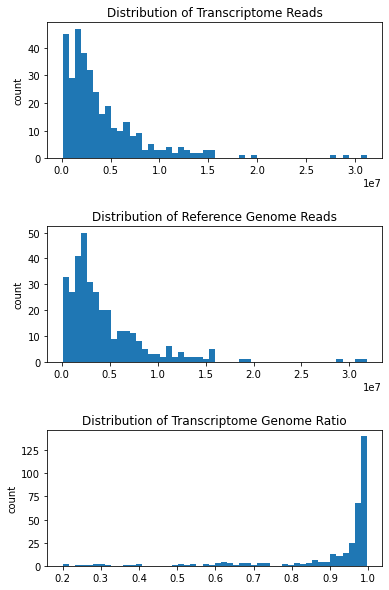

In [102]:


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.hist(sra['TRANSCRIPTOME READS'], bins=50)
ax1.set_title('Distribution of Transcriptome Reads')
ax1.set_ylabel('count')
ax2.hist(sra['REFERENCE GENOME READS'], bins=50)
ax2.set_title('Distribution of Reference Genome Reads')
ax2.set_ylabel('count')
ax3.hist(sra['TRANSCRIPTOME GENOME RATIO'], bins=50)
ax3.set_title('Distribution of Transcriptome Genome Ratio')
ax3.set_ylabel('count')
fig.subplots_adjust(hspace = 0.5)
fig.set_figheight(10)
plt.show()
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Distributions of reads and transcriptome genome ratio. </b>"))
sup_figNum += 1

### Tangle & Plaque Counts Distribution in Each Brain Region Broken Down By Conditions

We chose four brain regions(Frontal, Temporal, Hippocampal, and Entorhinal) and plotted the distributions of plaques and tangles of all three groups respectively.

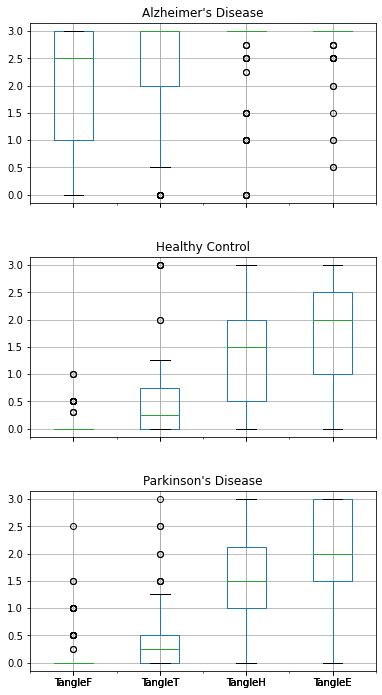

In [103]:
# Tangle counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'TangleF', 'TangleT', 'TangleH', 'TangleE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1), sharex=True)
plt.subplots_adjust(hspace = 0.3)
plt.savefig(os.path.join(plot_path, 'tangle_counts.png'))
plt.show()
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Tangle counts in each brain region. </b>"))
sup_figNum += 1

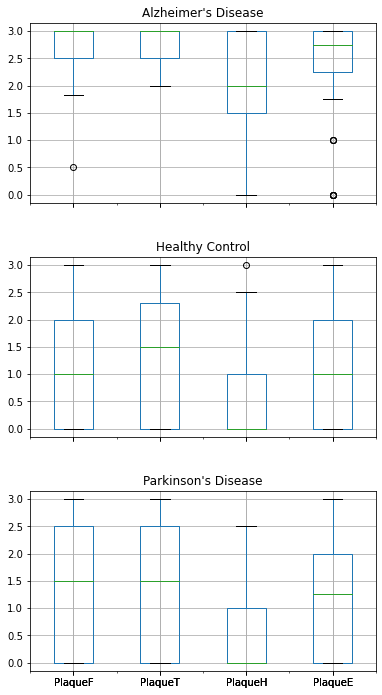

In [104]:
#Plaque counts distribution in each brain region broken down by contidions
plaques = sra[['CONDITION', 'PlaqueF', 'PlaqueT', 'PlaqueH', 'PlaqueE']]
plaques.groupby('CONDITION').boxplot(figsize=(6, 12), layout=(3, 1), sharex = True)
plt.subplots_adjust(hspace = 0.3)
plt.savefig(os.path.join(plot_path, 'plaque_counts.png'))
plt.show()
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Plaque counts in each brain region. </b>"))
sup_figNum += 1

The plots above show that the distribution of tangles and plaques of AD group is different to other groups as expected. However, the difference between PD and healthy control is not significant.

### Distributions of the overlapping miRNA Sequences

Below shows the distributions of the overlapping miRNA sequences. It is clear that the distributions of these sequences are significantly different between AD and PD groups in CSF samples.

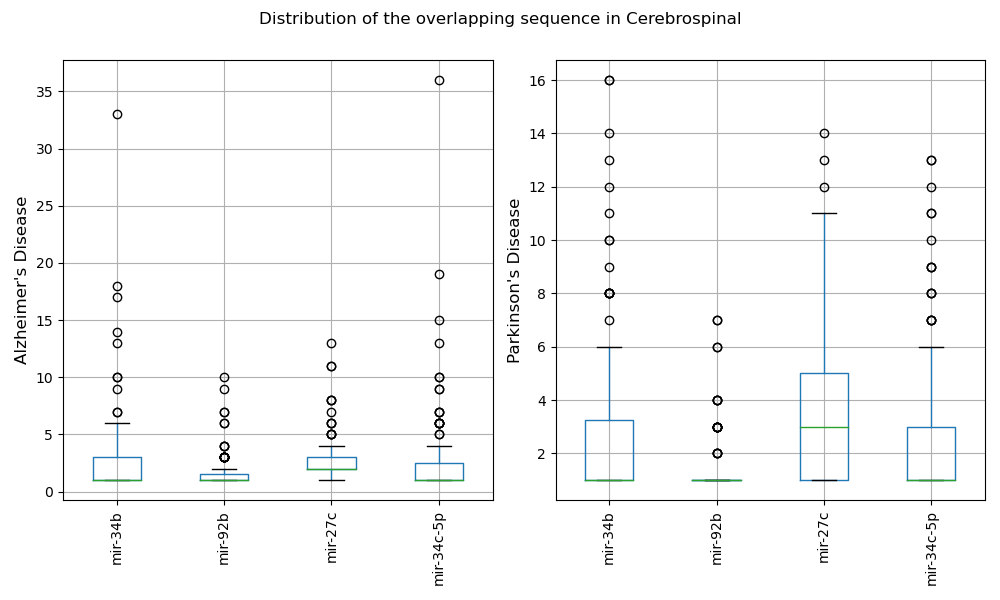

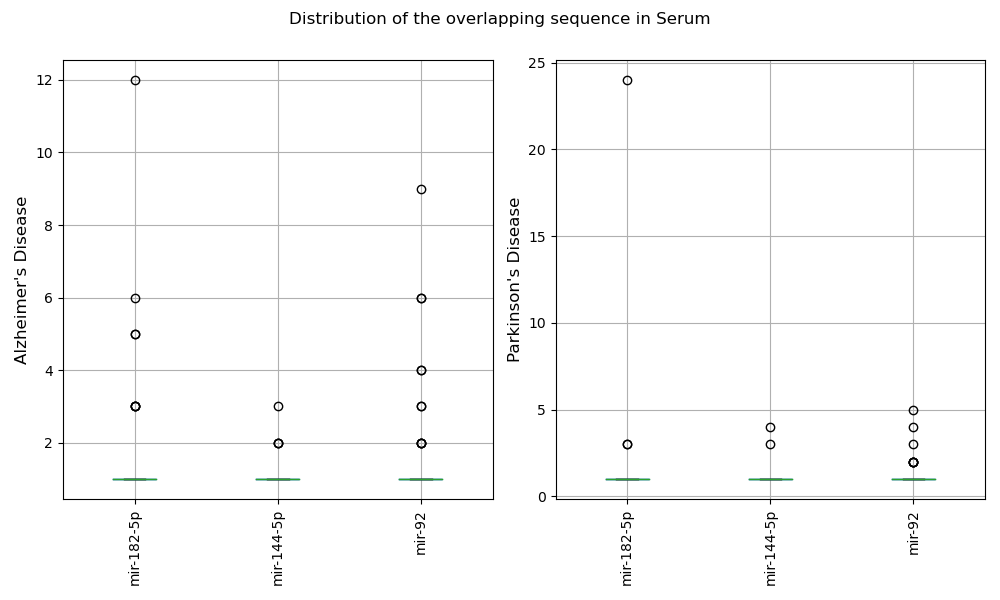

In [105]:
biofluid = ['Cerebrospinal', 'Serum']
for i in biofluid:
    display(Image(os.path.join(plot_path, "overlapping_distr_%s.png"%i), width=500))
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Distribution of overlapping miRNA in CSF and Serum. </b>"))
sup_figNum += 1
            

### Correlation between significantly regulated miRNA and numerical features

The plots below show the correlation between the significantly regulated miRNA found in the volcano plots above and the basic numerical features we used in the DESeq model. 

It appears that most of the up-regulated sequences in Cerebrospinal fluid of the Alzheimer's Disease group are weakly positively correlated with these numerical features, expecially with `PlaqueTotal`, `TangleTotal`, `Braak score`, and `sn_depigmentation`. And the sequences in Serum of the Parkinson's Disease group are mostly negatively correlated. However, the correlations with numerical features are not particularly strong.

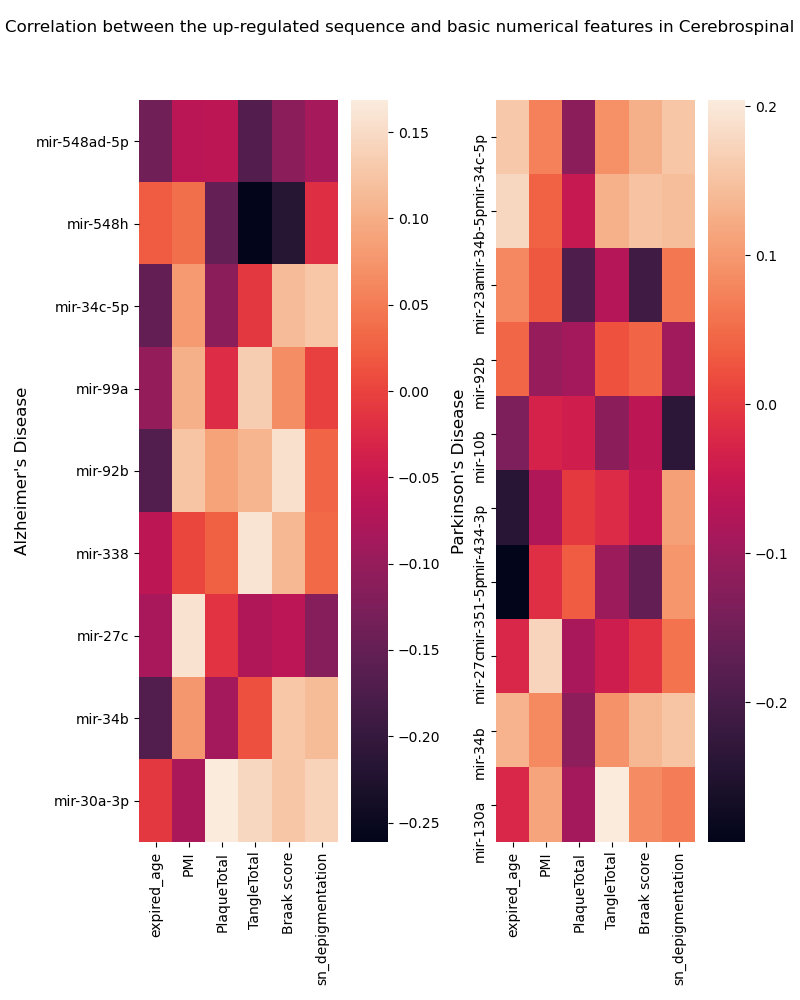

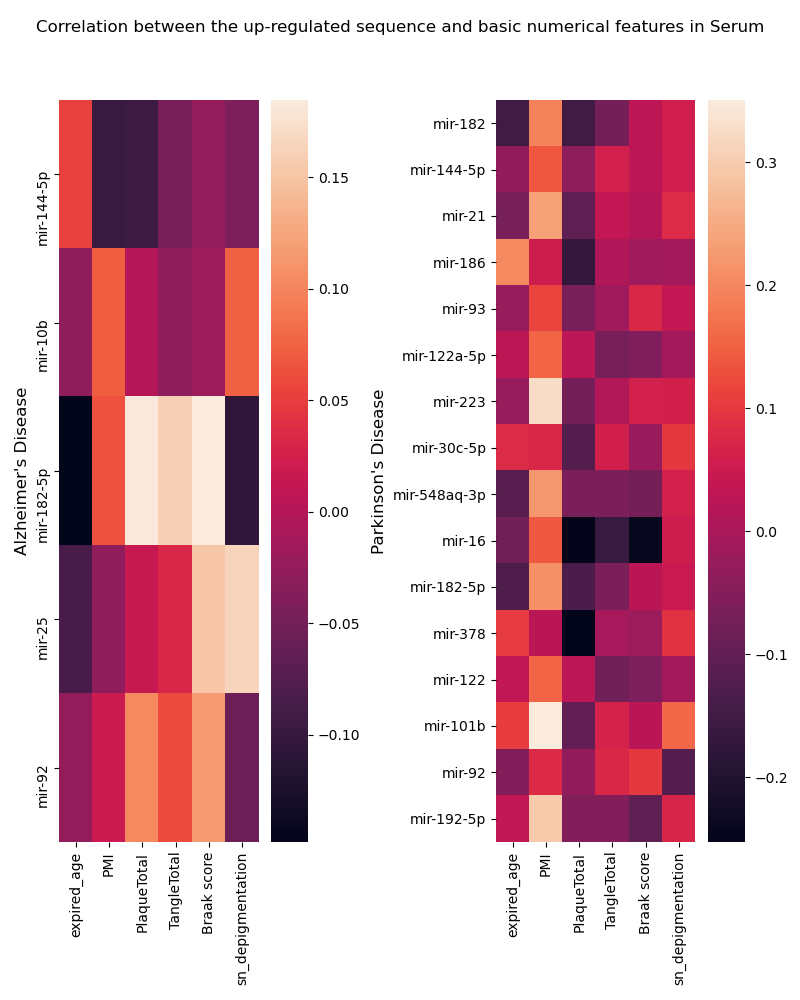

In [106]:
biofluid = ['Cerebrospinal', 'Serum']
for i in biofluid:
    display(Image("../data/out/up-regulated_corr_%s.png"%i, width=500))
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Correlation between up-regulated miRNA and numerical features in CSF and Serum. </b>"))
sup_figNum += 1


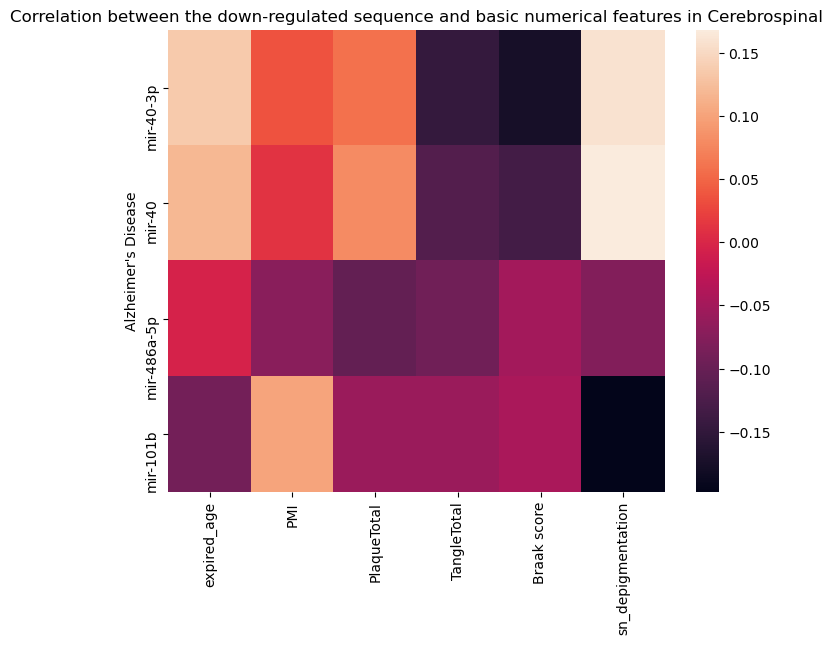

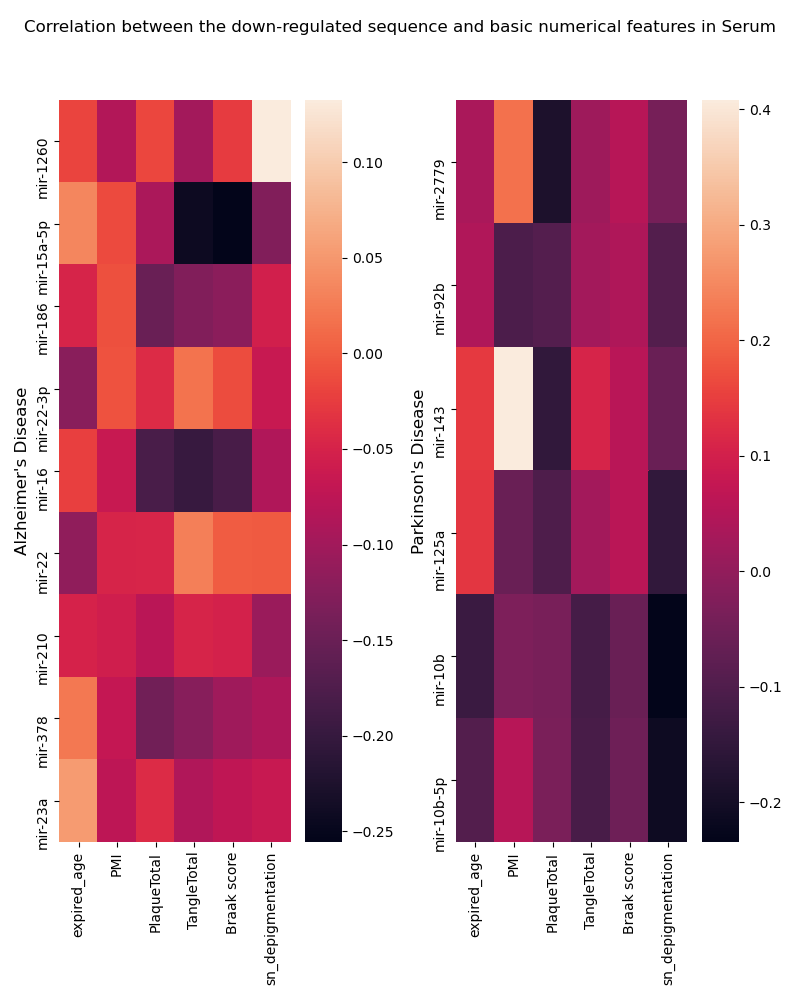

In [107]:
biofluid = ['Cerebrospinal', 'Serum']
for i in biofluid:
    display(Image("../data/out/down-regulated_corr_%s.png"%i, width=500))
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Correlation between down-regulated miRNA and numerical features in CSF and Serum. </b>"))
sup_figNum += 1

### Correlation between overlapping miRNA and numerical features

The plot below shows the correlation between overlapping miRNA and some basic numerical features. As stated in the report, none of the correlations is particularly strong enough to lead to meaningful conclusions.

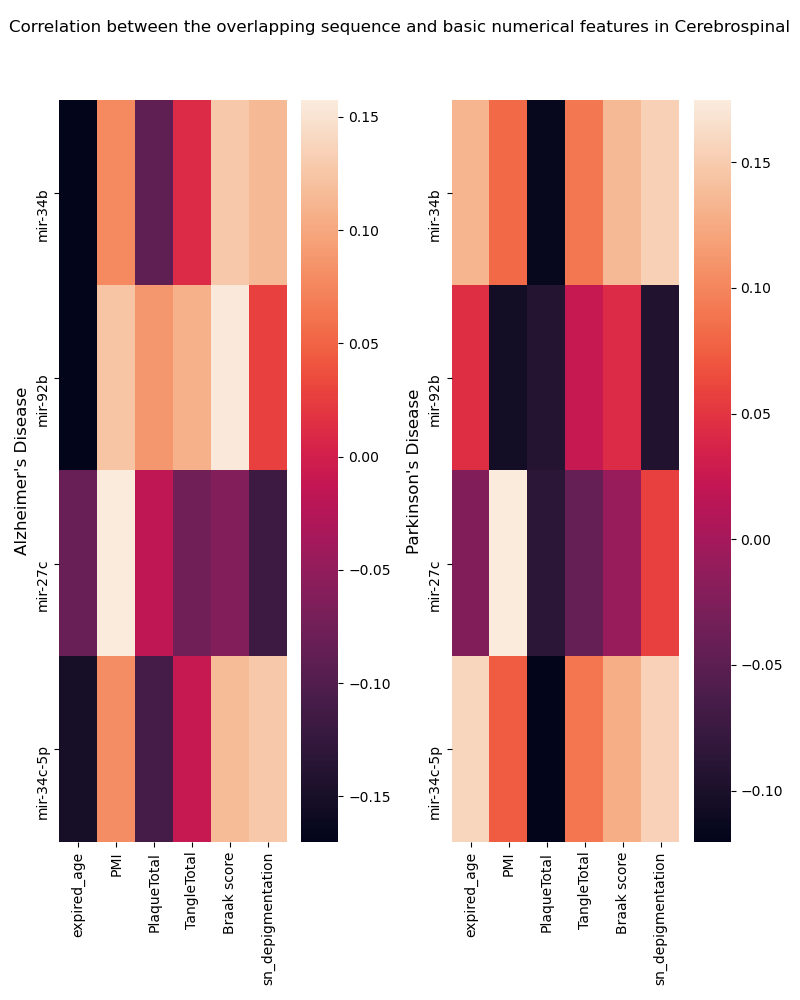

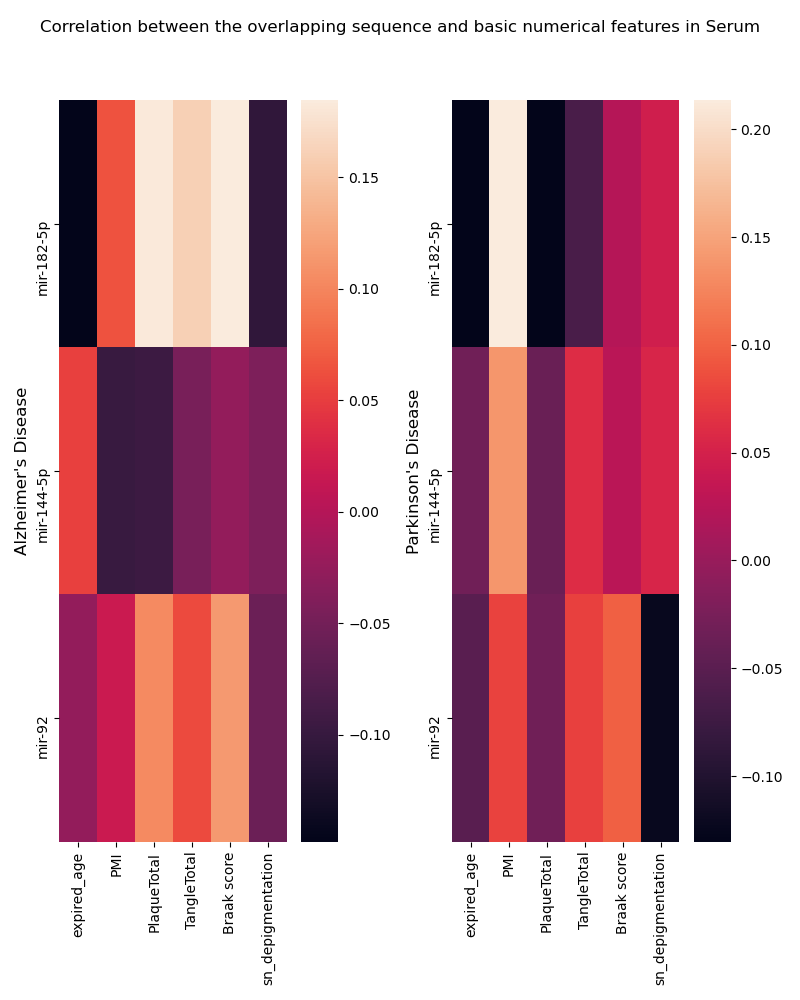

In [108]:
biofluid = ['Cerebrospinal', 'Serum']
for i in biofluid:
    display(Image("../data/out/overlapping_corr_%s.png"%i, width=500))
display(HTML("<b>Supplementary Figure "+str(sup_figNum)+": Correlation between overlapping miRNA and numerical features in CSF and Serum. </b>"))
sup_figNum += 1

## References TODO




SER: 

[1]
<span id="fn1">
miRNA analysis for PD/AD paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094839#s5 
</span>

[2] 
<span id="fn2">
AD: https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/symptoms-causes/syc-20350447<br>
</span>

[3] 
<span id="fn3">
PD: https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055 <br>
</span>

[4] 
<span id="fn4">
miRNA: https://www.frontiersin.org/articles/10.3389/fendo.2018.00402/full
</span>

[5]
<span id="fn5">
CSF: https://www.nationalmssociety.org/Symptoms-Diagnosis/Diagnosing-Tools/Cerebrospinal-Fluid-(CSF)
</span>

[6]
<span id="fn6">
serum: https://sciencing.com/what-is-serum-4673561.html
</span>

[7]
<span id="fn7">
serum and miRNA: https://www.3d-gene.com/en/products/dna/dna_004.html#:~:text=miRNAs%20are%20considered%20to%20exist,degraded%20by%20RNA%20degradation%20enzymes.
</span>

[8]
<span id="fn8">
ERCC Quality Control Standards: https://exrna.org/resources/data/data-quality-control-standards/
</span>

[9]
<span id="fn9">
LRT, URL: http://evomics.org/resources/likelihood-ratio-test/
</span>

[10]
<span id="fn10">
Heatmap, URL: https://chartio.com/learn/charts/heatmap-complete-guide/ 
</span>

[11]
<span id="fn11">
VST URL: https://en.wikipedia.org/wiki/Variance-stabilizing_transformation
</span>

[12]
<span id="fn12">
Understanding Normalization, URL:https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Similarly%2C%20the%20goal%20of%20normalization,in%20the%20ranges%20of%20values.&text=So%20we%20normalize%20the%20data,variables%20to%20the%20same%20range.
</span>

[13]
<span id="fn13">
Diana Kwon, Are Some Psychiatric Disorders a pH Problem? URL: https://www.scientificamerican.com/article/are-some-psychiatric-disorders-a-ph-problem/
</span>

[14]
<span id="fn14">
Pandas - Merge Function URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
</span>

[15]
<span id="fn15">
DESeq2: Love et al. Genome Biology (2014) URL: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
</span>

[16]
<span id="fn16">
Plaque + tangle: https://www.news-medical.net/health/Alzheimers-tangles-and-plaques-whats-the-difference.aspx
</span>

[17]
<span id="fn17">
braak staging: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605160/
</span>

[18]
<span id="fn18">
lewy body: https://www.nia.nih.gov/health/what-lewy-body-dementia 
</span>

[19]
<span id="fn19">
NIA-R: https://www.radc.rush.edu/docs/var/detail.htm;jsessionid=6669B3F472A33D97E802696844DC75CD?category=Pathology&subcategory=Alzheimer%27s+disease&variable=niareagansc
</span>

[20]
<span id="fn20">
sn depigmentation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3660013/
</span>

[21]
<span id="fn20">
(Poewe, W., Seppi,K., Tanner, C. et al. Parkinson disease. Nat Rev Dis Primers 3, 17013 (2017). https://doi.org/10.1038/nrdp.2017.13)
</span>